In [0]:
#!ps ax | grep python
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np

# Image Classification with Convolutional Neural Networks

**Welcome to the first week of the deep learning study group! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.**

### Introduction to our first task: 'Ants vs Bees'

There are 224 labelled Ants and Bees available for training. We are going to build a model to classify these images very accurately using a pre-trained model. This is easy to train on a CPU. After that we are going to train a similar model to classify Dogs vs Cats but this will require a GPU to train reasonably fast.

### Introduction to our second task: 'Dogs vs Cats'
We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

# Ants Vs Bees

In [2]:
#@title Import PyTorch modules if they are not present
!pip3 install torch torchvision
!pip3 install tqdm
!git clone https://github.com/kswamy15/dlnerds
#!rm -r dlnerds

fatal: destination path 'dlnerds' already exists and is not an empty directory.


In [3]:
ls

datalab/  dlnerds/


In [0]:
#!rm -r dlnerds

In [4]:
## Import the Ants vs Bees data if not already present
if not os.path.isfile('hymenoptera_data.zip'):
  !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
  !unzip hymenoptera_data.zip  -d data

--2018-05-07 23:43:34--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.27.114, 54.192.27.182, 54.192.27.159, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.27.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  26.4MB/s    in 1.7s    

2018-05-07 23:43:36 (26.4 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: data/hymenoptera_data/
   creating: data/hymenoptera_data/train/
   creating: data/hymenoptera_data/train/ants/
  inflating: data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: data/hymenoptera_data/train/ants/1099452230_d1949d3250


  inflating: data/hymenoptera_data/val/ants/desert_ant.jpg  
  inflating: data/hymenoptera_data/val/ants/F.pergan.28(f).jpg  
  inflating: data/hymenoptera_data/val/ants/Hormiga.jpg  
   creating: data/hymenoptera_data/val/bees/
  inflating: data/hymenoptera_data/val/bees/1032546534_06907fe3b3.jpg  
  inflating: data/hymenoptera_data/val/bees/10870992_eebeeb3a12.jpg  
  inflating: data/hymenoptera_data/val/bees/1181173278_23c36fac71.jpg  
  inflating: data/hymenoptera_data/val/bees/1297972485_33266a18d9.jpg  
  inflating: data/hymenoptera_data/val/bees/1328423762_f7a88a8451.jpg  
  inflating: data/hymenoptera_data/val/bees/1355974687_1341c1face.jpg  
  inflating: data/hymenoptera_data/val/bees/144098310_a4176fd54d.jpg  
  inflating: data/hymenoptera_data/val/bees/1486120850_490388f84b.jpg  
  inflating: data/hymenoptera_data/val/bees/149973093_da3c446268.jpg  
  inflating: data/hymenoptera_data/val/bees/151594775_ee7dc17b60.jpg  
  inflating: data/hymenoptera_data/val/bees/151603988_2

In [5]:
!ls data/

hymenoptera_data


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

In [0]:
from dlnerds.dllib import train as train
from dlnerds.dllib.utils import plot_confusion_matrix as plot_confusion_matrix
from dlnerds.dllib import lr_sched as lr_sched
plt.ion()   # interactive mode

## Transforms
[See all the different pre-defined Transforms of Pytorch here ](http://pytorch.org/docs/master/torchvision/transforms.html)  Data augmentation and normalization for training.  The normalization parameters come from the Imagenet data.  We can try other types of transformations.  The Crop(224) is there to bring all the images to 224 x 224 size.  This is the size of the Imagenet pictures. Just normalization for validation.  The Transformations won't change the original data, just applies the transforms to the dat before it is used in the training loop.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
test1 = transforms.RandomHorizontalFlip()

In [0]:
??transforms.RandomResizedCrop

In [0]:
from PIL import Image
img = Image.open('data/hymenoptera_data/train/ants/224655713_3956f7d39a.jpg')

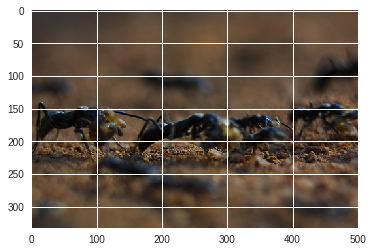

In [13]:
plt.imshow(img)

In [0]:
crop_image = test1(img)

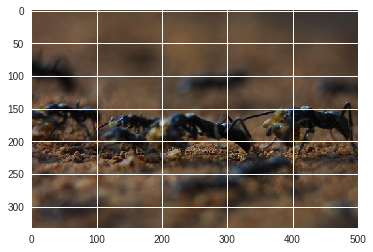

In [20]:
plt.imshow(crop_image)

## Datasets and DataLoaders
Load the Data into a Pytorch Dataset along with the pre-defined transforms.  The DataLoader is the primary way to build batches of data in Pytorch for training.  The dataloader has to be fed a Dataset object that contains the class name and the image data of each class.  Datasets has a ImageFolder function that can load image data that is stored under folder names of the various classes.  

In [0]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#check if GPU is available
use_gpu = torch.cuda.is_available()

In [0]:
?datasets.ImageFolder

## See some Sample Images

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

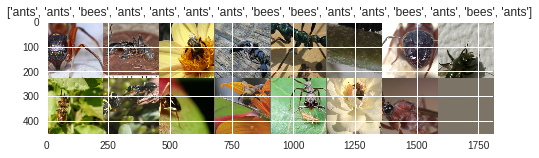

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model using a pre-trained Resnet model
We are not going to train any of the weights of the pre-trained model except for the last fully connected layer. Imagenet model has 1000 classes.  The Resnet model was trained on the imagenet data.  We are going to replace the last fully connected unit with 2 classes and train that last unit to recognize the ants vs bees.

In [12]:
base_model = torchvision.models.resnet18(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 34047133.12it/s]


In [33]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)

In [0]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return x
    
    def calculate_loss(self, outputs, targets, **kwargs):
        return F.nll_loss(input=outputs, target=targets)

    def calculate_metrics(self, outputs, targets, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return classification_accuracy

In [0]:
model_conv = MyModel(base_model)

if torch.cuda.is_available():
    model_conv.cuda()

## Summary of Resnet Model

In [39]:
model_conv

MyModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [0]:
from dlnerds.dllib.model import model_summary 

## Define a Loss function.  
CrossEntropy Loss works very well for training multi class images - with one class per image.  The Loss function also defines the learning parameter and a momentum variable

In [0]:
# Observe that only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_conv.base_model.fc.parameters(), lr=0.001, momentum=0.9)

## Define the Training Model using the Trainer class.  
See details of Trainer class in the github repository

In [0]:
train_conv = train.Trainer(model_conv,dataloaders['train'],dataloaders['val'],optimizer_conv)

## Find the optimum learning rate to start training
Before we start training the model, we would like to find the optimum learning rate to begin with so that the model can be trained faster.  

The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

  0%|          | 0/17 [00:00<?, ?it/s]

Trying learning rates between 1e-05 and 10 over 30 steps (2 epochs)
Epoch 0/1
----------


  6%|▌         | 1/17 [00:00<00:05,  3.19it/s]

Iteration No:1 Learn rate 1.00E-05 Batch Loss: 0.9024 Batch Accuracy: 0.2667 


 12%|█▏        | 2/17 [00:00<00:04,  3.45it/s]

Iteration No:2 Learn rate 1.58E-05 Batch Loss: 0.9220 Batch Accuracy: 0.2667 


 18%|█▊        | 3/17 [00:00<00:04,  3.34it/s]

Iteration No:3 Learn rate 2.51E-05 Batch Loss: 0.8336 Batch Accuracy: 0.2667 


 24%|██▎       | 4/17 [00:01<00:03,  3.48it/s]

Iteration No:4 Learn rate 3.98E-05 Batch Loss: 0.7783 Batch Accuracy: 0.4000 


 29%|██▉       | 5/17 [00:01<00:03,  3.62it/s]

Iteration No:5 Learn rate 6.31E-05 Batch Loss: 0.7296 Batch Accuracy: 0.4000 


 35%|███▌      | 6/17 [00:01<00:02,  3.72it/s]

Iteration No:6 Learn rate 1.00E-04 Batch Loss: 0.8153 Batch Accuracy: 0.3333 


 41%|████      | 7/17 [00:01<00:02,  3.74it/s]

Iteration No:7 Learn rate 1.58E-04 Batch Loss: 0.9105 Batch Accuracy: 0.2000 


 47%|████▋     | 8/17 [00:02<00:02,  3.77it/s]

Iteration No:8 Learn rate 2.51E-04 Batch Loss: 0.8332 Batch Accuracy: 0.4000 


 53%|█████▎    | 9/17 [00:02<00:02,  3.78it/s]

Iteration No:9 Learn rate 3.98E-04 Batch Loss: 0.9205 Batch Accuracy: 0.3333 


 59%|█████▉    | 10/17 [00:02<00:01,  3.80it/s]

Iteration No:10 Learn rate 6.31E-04 Batch Loss: 0.6506 Batch Accuracy: 0.6667 


 65%|██████▍   | 11/17 [00:02<00:01,  3.84it/s]

Iteration No:11 Learn rate 1.00E-03 Batch Loss: 0.9333 Batch Accuracy: 0.5333 


 71%|███████   | 12/17 [00:03<00:01,  3.86it/s]

Iteration No:12 Learn rate 1.58E-03 Batch Loss: 0.9455 Batch Accuracy: 0.4000 


 76%|███████▋  | 13/17 [00:03<00:01,  3.73it/s]

Iteration No:13 Learn rate 2.51E-03 Batch Loss: 0.7755 Batch Accuracy: 0.4667 


 82%|████████▏ | 14/17 [00:03<00:00,  3.77it/s]

Iteration No:14 Learn rate 3.98E-03 Batch Loss: 0.7067 Batch Accuracy: 0.4667 


 88%|████████▊ | 15/17 [00:03<00:00,  3.77it/s]

Iteration No:15 Learn rate 6.31E-03 Batch Loss: 0.4498 Batch Accuracy: 0.7333 


  0%|          | 0/17 [00:00<?, ?it/s]

Iteration No:16 Learn rate 1.00E-02 Batch Loss: 0.6054 Batch Accuracy: 0.6000 
Iteration No:17 Learn rate 1.58E-02 Batch Loss: 1.2028 Batch Accuracy: 0.5000 
Epoch 1/1
----------


  6%|▌         | 1/17 [00:00<00:05,  2.68it/s]

Iteration No:18 Learn rate 2.51E-02 Batch Loss: 0.2754 Batch Accuracy: 0.8000 


 12%|█▏        | 2/17 [00:00<00:04,  3.25it/s]

Iteration No:19 Learn rate 3.98E-02 Batch Loss: 4.7704 Batch Accuracy: 0.3333 


 18%|█▊        | 3/17 [00:00<00:03,  3.52it/s]

Iteration No:20 Learn rate 6.31E-02 Batch Loss: 0.6545 Batch Accuracy: 0.6667 


 24%|██▎       | 4/17 [00:01<00:03,  3.66it/s]

Iteration No:21 Learn rate 1.00E-01 Batch Loss: 9.4579 Batch Accuracy: 0.4000 


 29%|██▉       | 5/17 [00:01<00:03,  3.74it/s]

Iteration No:22 Learn rate 1.58E-01 Batch Loss: 2.4261 Batch Accuracy: 0.8000 


 35%|███▌      | 6/17 [00:01<00:02,  3.76it/s]

Iteration No:23 Learn rate 2.51E-01 Batch Loss: 0.1082 Batch Accuracy: 0.9333 
Iteration No:24 Learn rate 3.98E-01 Batch Loss: 6.7206 Batch Accuracy: 0.7333 


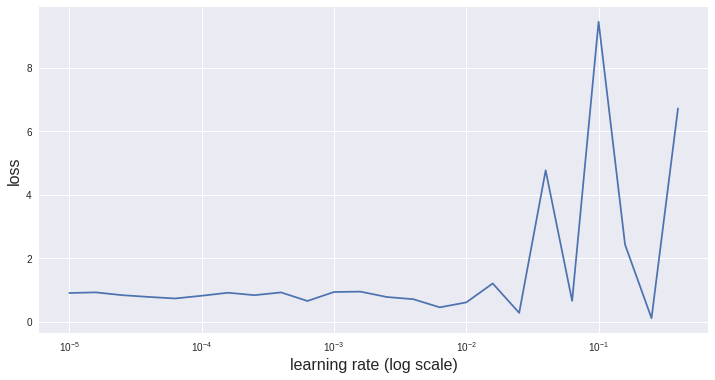

In [18]:
train_conv.lr_find(steps=30)

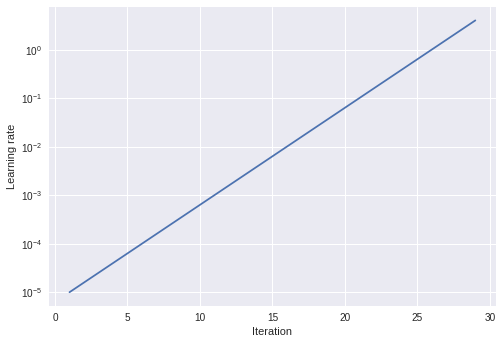

In [114]:
train_conv.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/num_iterations) of SGD.

## Train the model
Specify the number of epochs to train the model

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/1
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.3189 Acc: 0.8566


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.2007 Acc: 0.9412

Epoch 1/1
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2868 Acc: 0.8607


100%|██████████| 11/11 [00:02<00:00,  3.88it/s]


val Loss: 0.1851 Acc: 0.9542

Training complete in 0m 14s
Best val Acc: 0.954248


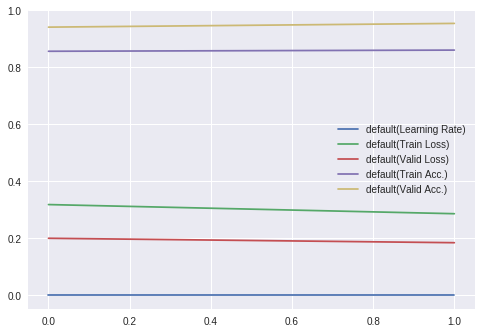

In [24]:
train_conv.train_model(num_epochs=2)

## Plot the confusion matrix

100%|██████████| 11/11 [00:02<00:00,  4.59it/s]


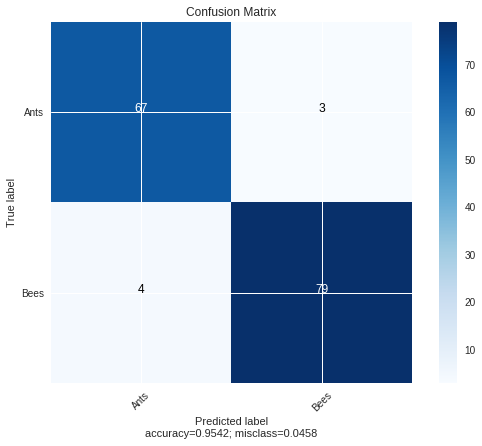

In [25]:
probs,target = train_conv.predict_with_targs()
preds = np.argmax(probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, preds)
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Ants', 'Bees'],
                      title        = "Confusion Matrix")

## Improving our model
Data augmentation
If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

Try Different transforms

### stochastic gradient descent with restarts (SGDR)
A variant of learning rate annealing, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

---



In [0]:
optimizer_sched = optim.SGD(model_conv.base_model.fc.parameters(), lr=0.002, momentum=0.9)

In [0]:
lr_scheduler_conv = lr_sched.myCosineAnnealingLR(optimizer_sched,15,cycle_mult=2)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2396 Acc: 0.8934


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1572 Acc: 0.9542

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2055 Acc: 0.9098


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1782 Acc: 0.9412

Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2469 Acc: 0.9016


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1648 Acc: 0.9412

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2453 Acc: 0.9180


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1607 Acc: 0.9477

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1877 Acc: 0.9139


100%|██████████| 11/11 [00:02<00:00,  3.70it/s]


val Loss: 0.1526 Acc: 0.9477

Training complete in 0m 36s
Best val Acc: 0.954248


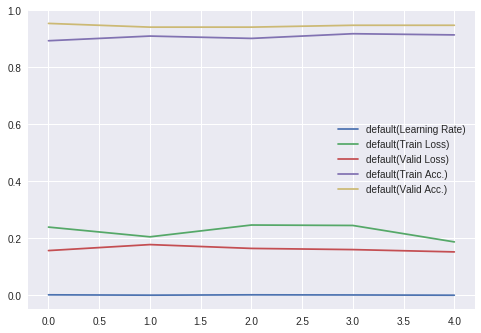

In [120]:
train_conv.train_model(optimizer=optimizer_sched,scheduler=lr_scheduler_conv,num_epochs=5)

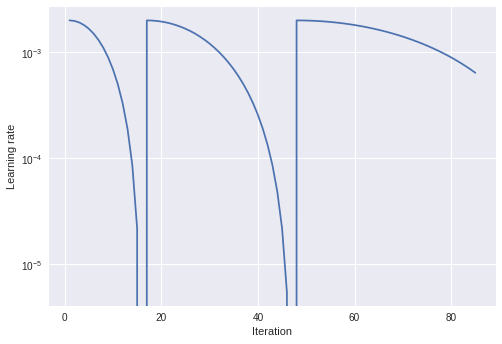

In [121]:
train_conv.plot_lr()

## Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. We are going to unfreeze other layers and train them using different learning rates.  We are going to unfreeze layer4 and layer3 and train them using a lower learning rate than the fully connected layer.  

In [0]:
for param in model_conv.base_model.layer4.parameters():
    param.requires_grad = True
for param in model_conv.base_model.layer3.parameters():
    param.requires_grad = True  
optimizer_conv = optim.SGD([{'params': model_conv.base_model.fc.parameters(), 'lr':1e-3},
                            {'params': model_conv.base_model.layer4.parameters(), 'lr':1e-4},
                            {'params': model_conv.base_model.layer3.parameters(), 'lr':5e-5}]
                           , lr=1e-4,momentum=0.9)    

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2053 Acc: 0.9139


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1557 Acc: 0.9542

Epoch 1/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2480 Acc: 0.8893


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1613 Acc: 0.9477

Epoch 2/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2079 Acc: 0.9098


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1738 Acc: 0.9477

Epoch 3/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.1894 Acc: 0.9221


  0%|          | 0/17 [00:00<?, ?it/s]

val Loss: 0.1538 Acc: 0.9477

Epoch 4/4
----------


  0%|          | 0/11 [00:00<?, ?it/s]

train Loss: 0.2215 Acc: 0.9221


100%|██████████| 11/11 [00:02<00:00,  3.79it/s]


val Loss: 0.2071 Acc: 0.9281

Training complete in 0m 39s
Best val Acc: 0.954248


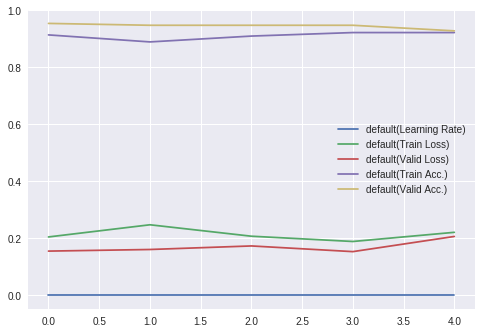

In [123]:
model_conv = train_conv.train_model(optimizer=optimizer_conv,num_epochs=5)

In [45]:
lr_scheduler_conv = lr_sched.myCosineAnnealingLR(optimizer_conv,15,cycle_mult=1)
model_conv = train_conv.train_model(optimizer=optimizer_conv,scheduler=lr_scheduler_conv, num_epochs=5)


  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/4
----------


KeyboardInterrupt: ignored

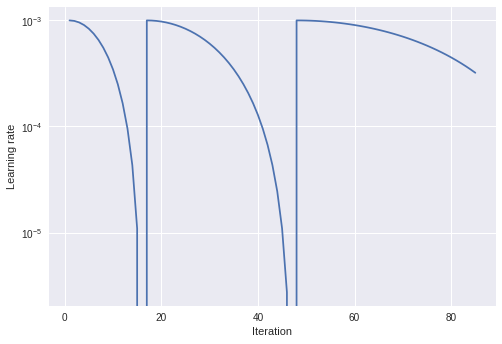

In [125]:
train_conv.plot_lr()

## Review: easy steps to train a world-class image classifier
1.  Enable data augmentation using Pytorch transforms
2.  Use lr_find() to find highest learning rate where loss is still clearly improving
3.  Train last layer from precomputed activations for 1-2 epochs
4.  Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5.  Unfreeze some layers
6.  Set earlier layers to 3x-10x lower learning rate than next higher layer
7.  Use lr_find() again
8.  Train full network with cycle_mult=2 until over-fitting

## Some helper function:
to check the free GPU memory

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Gen RAM Free: 11.3 GB  I Proc size: 1.8 GB
GPU RAM Free: 10806MB | Used: 633MB | Util   6% | Total 11439MB


# Dogs vs Cats

PATH is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. sz is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at 224 for now.

In [0]:
PATH = "data/dogscats/"

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns True before you proceed. If you have problems with this, please check the FAQ and ask for help on the forums.

In [27]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return True, you may want to look into why.

In [28]:
torch.backends.cudnn.enabled

True

## Extra steps if NOT using Crestle or Paperspace or our scripts
The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. wget http://files.fast.ai/data/dogscats.zip. You should put the data in a subdirectory of this notebook's directory, called data/. Note that this data is already available in Crestle and the Paperspace fast.ai template.

In [29]:
## Import the Ants vs Bees data if not already present
if not os.path.isfile('dogscats.zip'):
  !wget http://files.fast.ai/data/dogscats.zip
  !unzip dogscats.zip  -d data

--2018-05-08 00:47:43--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip         66%[============>       ] 541.43M  11.0MB/s    eta 28s    

dogscats.zip        100%[===================>] 817.50M  8.30MB/s    in 76s     

2018-05-08 00:48:59 (10.8 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]

Archive:  dogscats.zip
   creating: data/dogscats/
   creating: data/dogscats/sample/
   creating: data/dogscats/sample/train/
   creating: data/dogscats/sample/train/cats/
  inflating: data/dogscats/sample/train/cats/cat.2921.jpg  
  inflating: data/dogscats/sample/train/cats/cat.394.jpg  
  inflating: data/dogscats/sample/train/cats/cat.4865.jpg  
  inflating: data/dogscats/sample/train/cats/cat.3570.jpg  
  inflating: data/dogscats/sample/train/cats/cat.2266.jpg  
  inflating: data/dogscats/sample/train/cats/cat.9021.jpg  
  inflating: data/dogscats/sample/train/cats/cat.11737.jpg  
  inflating: data/dogscats/sample/train/cats/cat.4600.jpg  
   creating: data/dogscats/sample/train/dogs/
  inflating: data/dogscats/sample/train/dogs/dog.1402.jpg  
  inflating: data/dogscats/sample/train/dogs/dog.1614.jpg  
  inflating: data/dogs


  inflating: data/dogscats/train/cats/cat.1196.jpg  
  inflating: data/dogscats/train/cats/cat.5539.jpg  
  inflating: data/dogscats/train/cats/cat.5057.jpg  
  inflating: data/dogscats/train/cats/cat.7538.jpg  
  inflating: data/dogscats/train/cats/cat.9555.jpg  
  inflating: data/dogscats/train/cats/cat.5805.jpg  
  inflating: data/dogscats/train/cats/cat.4342.jpg  
  inflating: data/dogscats/train/cats/cat.11187.jpg  
  inflating: data/dogscats/train/cats/cat.10275.jpg  
  inflating: data/dogscats/train/cats/cat.8025.jpg  
  inflating: data/dogscats/train/cats/cat.9599.jpg  
  inflating: data/dogscats/train/cats/cat.2829.jpg  
  inflating: data/dogscats/train/cats/cat.8867.jpg  
  inflating: data/dogscats/train/cats/cat.5303.jpg  
  inflating: data/dogscats/train/cats/cat.6733.jpg  
  inflating: data/dogscats/train/cats/cat.9616.jpg  
  inflating: data/dogscats/train/cats/cat.9443.jpg  
  inflating: data/dogscats/train/cats/cat.6831.jpg  
  inflating: data/dogscats/train/cats/cat.4


  inflating: data/dogscats/train/cats/cat.10603.jpg  
  inflating: data/dogscats/train/cats/cat.7197.jpg  
  inflating: data/dogscats/train/cats/cat.5217.jpg  
  inflating: data/dogscats/train/cats/cat.8384.jpg  
  inflating: data/dogscats/train/cats/cat.12163.jpg  
  inflating: data/dogscats/train/cats/cat.11862.jpg  
  inflating: data/dogscats/train/cats/cat.3452.jpg  
  inflating: data/dogscats/train/cats/cat.4171.jpg  
  inflating: data/dogscats/train/cats/cat.1395.jpg  
  inflating: data/dogscats/train/cats/cat.6760.jpg  
  inflating: data/dogscats/train/cats/cat.1857.jpg  
  inflating: data/dogscats/train/cats/cat.11934.jpg  
  inflating: data/dogscats/train/cats/cat.4723.jpg  
  inflating: data/dogscats/train/cats/cat.9964.jpg  
  inflating: data/dogscats/train/cats/cat.12243.jpg  
  inflating: data/dogscats/train/cats/cat.10995.jpg  
  inflating: data/dogscats/train/cats/cat.11088.jpg  
  inflating: data/dogscats/train/cats/cat.1484.jpg  
  inflating: data/dogscats/train/cats/


  inflating: data/dogscats/train/cats/cat.11640.jpg  
  inflating: data/dogscats/train/cats/cat.1608.jpg  
  inflating: data/dogscats/train/cats/cat.3764.jpg  
  inflating: data/dogscats/train/cats/cat.1999.jpg  
  inflating: data/dogscats/train/cats/cat.5429.jpg  
  inflating: data/dogscats/train/cats/cat.6822.jpg  
  inflating: data/dogscats/train/cats/cat.7779.jpg  
  inflating: data/dogscats/train/cats/cat.1315.jpg  
  inflating: data/dogscats/train/cats/cat.9685.jpg  
  inflating: data/dogscats/train/cats/cat.1424.jpg  
  inflating: data/dogscats/train/cats/cat.3635.jpg  
  inflating: data/dogscats/train/cats/cat.4368.jpg  
  inflating: data/dogscats/train/cats/cat.403.jpg  
  inflating: data/dogscats/train/cats/cat.4438.jpg  
  inflating: data/dogscats/train/cats/cat.2565.jpg  
  inflating: data/dogscats/train/cats/cat.4705.jpg  
  inflating: data/dogscats/train/cats/cat.3272.jpg  
  inflating: data/dogscats/train/cats/cat.2590.jpg  
  inflating: data/dogscats/train/cats/cat.761


  inflating: data/dogscats/train/cats/cat.4830.jpg  
  inflating: data/dogscats/train/cats/cat.3085.jpg  
  inflating: data/dogscats/train/cats/cat.10372.jpg  
  inflating: data/dogscats/train/cats/cat.7965.jpg  
  inflating: data/dogscats/train/cats/cat.12397.jpg  
  inflating: data/dogscats/train/cats/cat.463.jpg  
  inflating: data/dogscats/train/cats/cat.7392.jpg  
  inflating: data/dogscats/train/cats/cat.5892.jpg  
  inflating: data/dogscats/train/cats/cat.10662.jpg  
  inflating: data/dogscats/train/cats/cat.5812.jpg  
  inflating: data/dogscats/train/cats/cat.5936.jpg  
  inflating: data/dogscats/train/cats/cat.1036.jpg  
  inflating: data/dogscats/train/cats/cat.805.jpg  
  inflating: data/dogscats/train/cats/cat.2614.jpg  
  inflating: data/dogscats/train/cats/cat.3679.jpg  
  inflating: data/dogscats/train/cats/cat.11030.jpg  
  inflating: data/dogscats/train/cats/cat.9415.jpg  
  inflating: data/dogscats/train/cats/cat.1934.jpg  
  inflating: data/dogscats/train/cats/cat.1


  inflating: data/dogscats/train/cats/cat.2057.jpg  
  inflating: data/dogscats/train/cats/cat.4331.jpg  
  inflating: data/dogscats/train/cats/cat.9679.jpg  
  inflating: data/dogscats/train/cats/cat.10363.jpg  
  inflating: data/dogscats/train/cats/cat.4292.jpg  
  inflating: data/dogscats/train/cats/cat.7592.jpg  
  inflating: data/dogscats/train/cats/cat.904.jpg  
  inflating: data/dogscats/train/cats/cat.7360.jpg  
  inflating: data/dogscats/train/cats/cat.1640.jpg  
  inflating: data/dogscats/train/cats/cat.12442.jpg  
  inflating: data/dogscats/train/cats/cat.7187.jpg  
  inflating: data/dogscats/train/cats/cat.7795.jpg  
  inflating: data/dogscats/train/cats/cat.6557.jpg  
  inflating: data/dogscats/train/cats/cat.5119.jpg  
  inflating: data/dogscats/train/cats/cat.3416.jpg  
  inflating: data/dogscats/train/cats/cat.8850.jpg  
  inflating: data/dogscats/train/cats/cat.9701.jpg  
  inflating: data/dogscats/train/cats/cat.7236.jpg  
  inflating: data/dogscats/train/cats/cat.88


  inflating: data/dogscats/train/cats/cat.1039.jpg  
  inflating: data/dogscats/train/cats/cat.6703.jpg  
  inflating: data/dogscats/train/cats/cat.9600.jpg  
  inflating: data/dogscats/train/cats/cat.6494.jpg  
  inflating: data/dogscats/train/cats/cat.1423.jpg  
  inflating: data/dogscats/train/cats/cat.242.jpg  
  inflating: data/dogscats/train/cats/cat.741.jpg  
  inflating: data/dogscats/train/cats/cat.12178.jpg  
  inflating: data/dogscats/train/cats/cat.10622.jpg  
  inflating: data/dogscats/train/cats/cat.8389.jpg  
  inflating: data/dogscats/train/cats/cat.4863.jpg  
  inflating: data/dogscats/train/cats/cat.1221.jpg  
  inflating: data/dogscats/train/cats/cat.3345.jpg  
  inflating: data/dogscats/train/cats/cat.2223.jpg  
  inflating: data/dogscats/train/cats/cat.10322.jpg  
  inflating: data/dogscats/train/cats/cat.4163.jpg  
  inflating: data/dogscats/train/cats/cat.9736.jpg  
  inflating: data/dogscats/train/cats/cat.1772.jpg  
  inflating: data/dogscats/train/cats/cat.81

  inflating: data/dogscats/train/cats/cat.7766.jpg  
  inflating: data/dogscats/train/cats/cat.2745.jpg  
  inflating: data/dogscats/train/cats/cat.8300.jpg  
  inflating: data/dogscats/train/cats/cat.4808.jpg  
  inflating: data/dogscats/train/cats/cat.1332.jpg  
  inflating: data/dogscats/train/cats/cat.7539.jpg  
  inflating: data/dogscats/train/cats/cat.4082.jpg  
  inflating: data/dogscats/train/cats/cat.5927.jpg  
  inflating: data/dogscats/train/cats/cat.8756.jpg  
  inflating: data/dogscats/train/cats/cat.9573.jpg  
  inflating: data/dogscats/train/cats/cat.7383.jpg  
  inflating: data/dogscats/train/cats/cat.7469.jpg  
  inflating: data/dogscats/train/cats/cat.12297.jpg  
  inflating: data/dogscats/train/cats/cat.6520.jpg  
  inflating: data/dogscats/train/cats/cat.12005.jpg  
  inflating: data/dogscats/train/cats/cat.5886.jpg  
  inflating: data/dogscats/train/cats/cat.9793.jpg  
  inflating: data/dogscats/train/cats/cat.2241.jpg  
  inflating: data/dogscats/train/cats/cat.20

  inflating: data/dogscats/train/cats/cat.4130.jpg  
  inflating: data/dogscats/train/cats/cat.8339.jpg  
  inflating: data/dogscats/train/cats/cat.1888.jpg  
  inflating: data/dogscats/train/cats/cat.8269.jpg  
  inflating: data/dogscats/train/cats/cat.8446.jpg  
  inflating: data/dogscats/train/cats/cat.2425.jpg  
  inflating: data/dogscats/train/cats/cat.160.jpg  
  inflating: data/dogscats/train/cats/cat.1276.jpg  
  inflating: data/dogscats/train/cats/cat.10215.jpg  
  inflating: data/dogscats/train/cats/cat.9927.jpg  
  inflating: data/dogscats/train/cats/cat.6991.jpg  
  inflating: data/dogscats/train/cats/cat.8216.jpg  
  inflating: data/dogscats/train/cats/cat.5474.jpg  
  inflating: data/dogscats/train/cats/cat.1746.jpg  
  inflating: data/dogscats/train/cats/cat.1490.jpg  
  inflating: data/dogscats/train/cats/cat.9740.jpg  
  inflating: data/dogscats/train/cats/cat.5445.jpg  
  inflating: data/dogscats/train/cats/cat.8235.jpg  
  inflating: data/dogscats/train/cats/cat.1206


  inflating: data/dogscats/train/cats/cat.2544.jpg  
  inflating: data/dogscats/train/cats/cat.7933.jpg  
  inflating: data/dogscats/train/cats/cat.6238.jpg  
  inflating: data/dogscats/train/cats/cat.11477.jpg  
  inflating: data/dogscats/train/cats/cat.10937.jpg  
  inflating: data/dogscats/train/cats/cat.12452.jpg  
  inflating: data/dogscats/train/cats/cat.3934.jpg  
  inflating: data/dogscats/train/cats/cat.961.jpg  
  inflating: data/dogscats/train/cats/cat.6810.jpg  
  inflating: data/dogscats/train/cats/cat.8481.jpg  
  inflating: data/dogscats/train/cats/cat.7856.jpg  
  inflating: data/dogscats/train/cats/cat.6484.jpg  
  inflating: data/dogscats/train/cats/cat.12372.jpg  
  inflating: data/dogscats/train/cats/cat.1647.jpg  
  inflating: data/dogscats/train/cats/cat.10873.jpg  
  inflating: data/dogscats/train/cats/cat.3021.jpg  
  inflating: data/dogscats/train/cats/cat.3314.jpg  
  inflating: data/dogscats/train/cats/cat.5856.jpg  
  inflating: data/dogscats/train/cats/cat


  inflating: data/dogscats/train/cats/cat.723.jpg  
  inflating: data/dogscats/train/cats/cat.8995.jpg  
  inflating: data/dogscats/train/cats/cat.9601.jpg  
  inflating: data/dogscats/train/cats/cat.10157.jpg  
  inflating: data/dogscats/train/cats/cat.4039.jpg  
  inflating: data/dogscats/train/cats/cat.5937.jpg  
  inflating: data/dogscats/train/cats/cat.10477.jpg  
  inflating: data/dogscats/train/cats/cat.705.jpg  
  inflating: data/dogscats/train/cats/cat.615.jpg  
  inflating: data/dogscats/train/cats/cat.9215.jpg  
  inflating: data/dogscats/train/cats/cat.1194.jpg  
  inflating: data/dogscats/train/cats/cat.8337.jpg  
  inflating: data/dogscats/train/cats/cat.4321.jpg  
  inflating: data/dogscats/train/cats/cat.11633.jpg  
  inflating: data/dogscats/train/cats/cat.4615.jpg  
  inflating: data/dogscats/train/cats/cat.592.jpg  
  inflating: data/dogscats/train/cats/cat.11198.jpg  
  inflating: data/dogscats/train/cats/cat.11239.jpg  
  inflating: data/dogscats/train/cats/cat.19


  inflating: data/dogscats/train/cats/cat.5968.jpg  
  inflating: data/dogscats/train/cats/cat.2127.jpg  
  inflating: data/dogscats/train/cats/cat.4768.jpg  
  inflating: data/dogscats/train/cats/cat.7734.jpg  
  inflating: data/dogscats/train/cats/cat.5198.jpg  
  inflating: data/dogscats/train/cats/cat.1614.jpg  
  inflating: data/dogscats/train/cats/cat.4055.jpg  
  inflating: data/dogscats/train/cats/cat.2500.jpg  
  inflating: data/dogscats/train/cats/cat.5501.jpg  
  inflating: data/dogscats/train/cats/cat.12411.jpg  
  inflating: data/dogscats/train/cats/cat.2659.jpg  
  inflating: data/dogscats/train/cats/cat.3421.jpg  
  inflating: data/dogscats/train/cats/cat.3822.jpg  
  inflating: data/dogscats/train/cats/cat.10268.jpg  
  inflating: data/dogscats/train/cats/cat.2484.jpg  
  inflating: data/dogscats/train/cats/cat.6820.jpg  
  inflating: data/dogscats/train/cats/cat.2573.jpg  
  inflating: data/dogscats/train/cats/cat.3286.jpg  
  inflating: data/dogscats/train/cats/cat.8

  inflating: data/dogscats/train/cats/cat.2253.jpg  
  inflating: data/dogscats/train/cats/cat.1457.jpg  
  inflating: data/dogscats/train/cats/cat.371.jpg  
  inflating: data/dogscats/train/cats/cat.8679.jpg  
  inflating: data/dogscats/train/cats/cat.4997.jpg  
  inflating: data/dogscats/train/cats/cat.14.jpg  
  inflating: data/dogscats/train/cats/cat.6439.jpg  
  inflating: data/dogscats/train/cats/cat.1372.jpg  
  inflating: data/dogscats/train/cats/cat.3041.jpg  
  inflating: data/dogscats/train/cats/cat.9664.jpg  
  inflating: data/dogscats/train/cats/cat.6618.jpg  
  inflating: data/dogscats/train/cats/cat.9363.jpg  
  inflating: data/dogscats/train/cats/cat.11660.jpg  
  inflating: data/dogscats/train/cats/cat.8204.jpg  
  inflating: data/dogscats/train/cats/cat.4190.jpg  
  inflating: data/dogscats/train/cats/cat.5233.jpg  
  inflating: data/dogscats/train/cats/cat.1655.jpg  
  inflating: data/dogscats/train/cats/cat.5874.jpg  
  inflating: data/dogscats/train/cats/cat.1201.j

  inflating: data/dogscats/train/cats/cat.9061.jpg  
  inflating: data/dogscats/train/cats/cat.6956.jpg  
  inflating: data/dogscats/train/cats/cat.4339.jpg  
  inflating: data/dogscats/train/cats/cat.11119.jpg  
  inflating: data/dogscats/train/cats/cat.1272.jpg  
  inflating: data/dogscats/train/cats/cat.73.jpg  
  inflating: data/dogscats/train/cats/cat.10432.jpg  
  inflating: data/dogscats/train/cats/cat.2157.jpg  
  inflating: data/dogscats/train/cats/cat.7731.jpg  
  inflating: data/dogscats/train/cats/cat.10775.jpg  
  inflating: data/dogscats/train/cats/cat.2249.jpg  
  inflating: data/dogscats/train/cats/cat.7162.jpg  
  inflating: data/dogscats/train/cats/cat.10454.jpg  
  inflating: data/dogscats/train/cats/cat.10330.jpg  
  inflating: data/dogscats/train/cats/cat.1471.jpg  
  inflating: data/dogscats/train/cats/cat.12493.jpg  
  inflating: data/dogscats/train/cats/cat.4337.jpg  
  inflating: data/dogscats/train/cats/cat.6730.jpg  
  inflating: data/dogscats/train/cats/cat.

  inflating: data/dogscats/train/cats/cat.5889.jpg  
  inflating: data/dogscats/train/cats/cat.4000.jpg  
  inflating: data/dogscats/train/cats/cat.1762.jpg  
  inflating: data/dogscats/train/cats/cat.7899.jpg  
  inflating: data/dogscats/train/cats/cat.11357.jpg  
  inflating: data/dogscats/train/cats/cat.8413.jpg  
  inflating: data/dogscats/train/cats/cat.2951.jpg  
  inflating: data/dogscats/train/cats/cat.826.jpg  
  inflating: data/dogscats/train/cats/cat.4002.jpg  
  inflating: data/dogscats/train/cats/cat.2347.jpg  
  inflating: data/dogscats/train/cats/cat.5593.jpg  
  inflating: data/dogscats/train/cats/cat.6626.jpg  
  inflating: data/dogscats/train/cats/cat.2002.jpg  
  inflating: data/dogscats/train/cats/cat.11156.jpg  
  inflating: data/dogscats/train/cats/cat.2727.jpg  
  inflating: data/dogscats/train/cats/cat.3211.jpg  
  inflating: data/dogscats/train/cats/cat.7620.jpg  
  inflating: data/dogscats/train/cats/cat.883.jpg  
  inflating: data/dogscats/train/cats/cat.6707

  inflating: data/dogscats/train/cats/cat.3402.jpg  
  inflating: data/dogscats/train/cats/cat.5142.jpg  
  inflating: data/dogscats/train/cats/cat.3691.jpg  
  inflating: data/dogscats/train/cats/cat.4027.jpg  
  inflating: data/dogscats/train/cats/cat.12050.jpg  
  inflating: data/dogscats/train/cats/cat.10025.jpg  
  inflating: data/dogscats/train/cats/cat.3117.jpg  
  inflating: data/dogscats/train/cats/cat.11626.jpg  
  inflating: data/dogscats/train/cats/cat.2906.jpg  
  inflating: data/dogscats/train/cats/cat.885.jpg  
  inflating: data/dogscats/train/cats/cat.3125.jpg  
  inflating: data/dogscats/train/cats/cat.1387.jpg  
  inflating: data/dogscats/train/cats/cat.9214.jpg  
  inflating: data/dogscats/train/cats/cat.1618.jpg  
  inflating: data/dogscats/train/cats/cat.3812.jpg  
  inflating: data/dogscats/train/cats/cat.10350.jpg  
  inflating: data/dogscats/train/cats/cat.7259.jpg  
  inflating: data/dogscats/train/cats/cat.6428.jpg  
  inflating: data/dogscats/train/cats/cat.8


  inflating: data/dogscats/train/cats/cat.11184.jpg  
  inflating: data/dogscats/train/cats/cat.8623.jpg  
  inflating: data/dogscats/train/cats/cat.10109.jpg  
  inflating: data/dogscats/train/cats/cat.986.jpg  
  inflating: data/dogscats/train/cats/cat.2179.jpg  
  inflating: data/dogscats/train/cats/cat.10668.jpg  
  inflating: data/dogscats/train/cats/cat.3579.jpg  
  inflating: data/dogscats/train/cats/cat.2486.jpg  
  inflating: data/dogscats/train/cats/cat.8005.jpg  
  inflating: data/dogscats/train/cats/cat.8495.jpg  
  inflating: data/dogscats/train/cats/cat.890.jpg  
  inflating: data/dogscats/train/cats/cat.6191.jpg  
  inflating: data/dogscats/train/cats/cat.1575.jpg  
  inflating: data/dogscats/train/cats/cat.3145.jpg  
  inflating: data/dogscats/train/cats/cat.3522.jpg  
  inflating: data/dogscats/train/cats/cat.3864.jpg  
  inflating: data/dogscats/train/cats/cat.10225.jpg  
  inflating: data/dogscats/train/cats/cat.6916.jpg  
  inflating: data/dogscats/train/cats/cat.5


  inflating: data/dogscats/train/cats/cat.2645.jpg  
  inflating: data/dogscats/train/cats/cat.4240.jpg  
  inflating: data/dogscats/train/cats/cat.6028.jpg  
  inflating: data/dogscats/train/cats/cat.3393.jpg  
  inflating: data/dogscats/train/cats/cat.4765.jpg  
  inflating: data/dogscats/train/cats/cat.10017.jpg  
  inflating: data/dogscats/train/cats/cat.11411.jpg  
  inflating: data/dogscats/train/cats/cat.4563.jpg  
  inflating: data/dogscats/train/cats/cat.7349.jpg  
  inflating: data/dogscats/train/cats/cat.6498.jpg  
  inflating: data/dogscats/train/cats/cat.5644.jpg  
  inflating: data/dogscats/train/cats/cat.3053.jpg  
  inflating: data/dogscats/train/cats/cat.2092.jpg  
  inflating: data/dogscats/train/cats/cat.9485.jpg  
  inflating: data/dogscats/train/cats/cat.1637.jpg  
  inflating: data/dogscats/train/cats/cat.12456.jpg  
  inflating: data/dogscats/train/cats/cat.2083.jpg  
  inflating: data/dogscats/train/cats/cat.3030.jpg  
  inflating: data/dogscats/train/cats/cat.

  inflating: data/dogscats/train/cats/cat.4046.jpg  
  inflating: data/dogscats/train/cats/cat.6253.jpg  
  inflating: data/dogscats/train/cats/cat.543.jpg  
  inflating: data/dogscats/train/cats/cat.11512.jpg  
  inflating: data/dogscats/train/cats/cat.364.jpg  
  inflating: data/dogscats/train/cats/cat.5039.jpg  
  inflating: data/dogscats/train/cats/cat.733.jpg  
  inflating: data/dogscats/train/cats/cat.10060.jpg  
  inflating: data/dogscats/train/cats/cat.3525.jpg  
  inflating: data/dogscats/train/cats/cat.5791.jpg  
  inflating: data/dogscats/train/cats/cat.3892.jpg  
  inflating: data/dogscats/train/cats/cat.7841.jpg  
  inflating: data/dogscats/train/cats/cat.12104.jpg  
  inflating: data/dogscats/train/cats/cat.8265.jpg  
  inflating: data/dogscats/train/cats/cat.9364.jpg  
  inflating: data/dogscats/train/cats/cat.4091.jpg  
  inflating: data/dogscats/train/cats/cat.10348.jpg  
  inflating: data/dogscats/train/cats/cat.3398.jpg  
  inflating: data/dogscats/train/cats/cat.102

  inflating: data/dogscats/train/cats/cat.990.jpg  
  inflating: data/dogscats/train/cats/cat.3090.jpg  
  inflating: data/dogscats/train/cats/cat.769.jpg  
  inflating: data/dogscats/train/cats/cat.4603.jpg  
  inflating: data/dogscats/train/cats/cat.8369.jpg  
  inflating: data/dogscats/train/cats/cat.2608.jpg  
  inflating: data/dogscats/train/cats/cat.11844.jpg  
  inflating: data/dogscats/train/cats/cat.5790.jpg  
  inflating: data/dogscats/train/cats/cat.10413.jpg  
  inflating: data/dogscats/train/cats/cat.10524.jpg  
  inflating: data/dogscats/train/cats/cat.134.jpg  
  inflating: data/dogscats/train/cats/cat.6537.jpg  
  inflating: data/dogscats/train/cats/cat.11859.jpg  
  inflating: data/dogscats/train/cats/cat.2568.jpg  
  inflating: data/dogscats/train/cats/cat.8361.jpg  
  inflating: data/dogscats/train/cats/cat.12204.jpg  
  inflating: data/dogscats/train/cats/cat.11944.jpg  
  inflating: data/dogscats/train/cats/cat.4208.jpg  
  inflating: data/dogscats/train/cats/cat.2


  inflating: data/dogscats/train/dogs/dog.12184.jpg  
  inflating: data/dogscats/train/dogs/dog.8765.jpg  
  inflating: data/dogscats/train/dogs/dog.8010.jpg  
  inflating: data/dogscats/train/dogs/dog.424.jpg  
  inflating: data/dogscats/train/dogs/dog.1615.jpg  
  inflating: data/dogscats/train/dogs/dog.1212.jpg  
  inflating: data/dogscats/train/dogs/dog.6329.jpg  
  inflating: data/dogscats/train/dogs/dog.10337.jpg  
  inflating: data/dogscats/train/dogs/dog.226.jpg  
  inflating: data/dogscats/train/dogs/dog.8750.jpg  
  inflating: data/dogscats/train/dogs/dog.10929.jpg  
  inflating: data/dogscats/train/dogs/dog.7971.jpg  
  inflating: data/dogscats/train/dogs/dog.5091.jpg  
  inflating: data/dogscats/train/dogs/dog.1713.jpg  
  inflating: data/dogscats/train/dogs/dog.8244.jpg  
  inflating: data/dogscats/train/dogs/dog.445.jpg  
  inflating: data/dogscats/train/dogs/dog.80.jpg  
  inflating: data/dogscats/train/dogs/dog.10614.jpg  
  inflating: data/dogscats/train/dogs/dog.2539


  inflating: data/dogscats/train/dogs/dog.5262.jpg  
  inflating: data/dogscats/train/dogs/dog.2275.jpg  
  inflating: data/dogscats/train/dogs/dog.9181.jpg  
  inflating: data/dogscats/train/dogs/dog.10721.jpg  
  inflating: data/dogscats/train/dogs/dog.4330.jpg  
  inflating: data/dogscats/train/dogs/dog.7746.jpg  
  inflating: data/dogscats/train/dogs/dog.1957.jpg  
  inflating: data/dogscats/train/dogs/dog.1848.jpg  
  inflating: data/dogscats/train/dogs/dog.4250.jpg  
  inflating: data/dogscats/train/dogs/dog.10613.jpg  
  inflating: data/dogscats/train/dogs/dog.12346.jpg  
  inflating: data/dogscats/train/dogs/dog.7467.jpg  
  inflating: data/dogscats/train/dogs/dog.5947.jpg  
  inflating: data/dogscats/train/dogs/dog.5638.jpg  
  inflating: data/dogscats/train/dogs/dog.1225.jpg  
  inflating: data/dogscats/train/dogs/dog.7114.jpg  
  inflating: data/dogscats/train/dogs/dog.7055.jpg  
  inflating: data/dogscats/train/dogs/dog.9776.jpg  
  inflating: data/dogscats/train/dogs/dog.


  inflating: data/dogscats/train/dogs/dog.3400.jpg  
  inflating: data/dogscats/train/dogs/dog.4456.jpg  
  inflating: data/dogscats/train/dogs/dog.955.jpg  
  inflating: data/dogscats/train/dogs/dog.1455.jpg  
  inflating: data/dogscats/train/dogs/dog.936.jpg  
  inflating: data/dogscats/train/dogs/dog.1116.jpg  
  inflating: data/dogscats/train/dogs/dog.9913.jpg  
  inflating: data/dogscats/train/dogs/dog.5126.jpg  
  inflating: data/dogscats/train/dogs/dog.7941.jpg  
  inflating: data/dogscats/train/dogs/dog.891.jpg  
  inflating: data/dogscats/train/dogs/dog.3182.jpg  
  inflating: data/dogscats/train/dogs/dog.6112.jpg  
  inflating: data/dogscats/train/dogs/dog.9315.jpg  
  inflating: data/dogscats/train/dogs/dog.5492.jpg  
  inflating: data/dogscats/train/dogs/dog.3923.jpg  
  inflating: data/dogscats/train/dogs/dog.1035.jpg  
  inflating: data/dogscats/train/dogs/dog.4347.jpg  
  inflating: data/dogscats/train/dogs/dog.7593.jpg  
  inflating: data/dogscats/train/dogs/dog.1375.j

  inflating: data/dogscats/train/dogs/dog.12060.jpg  
  inflating: data/dogscats/train/dogs/dog.7710.jpg  
  inflating: data/dogscats/train/dogs/dog.5032.jpg  
  inflating: data/dogscats/train/dogs/dog.8247.jpg  
  inflating: data/dogscats/train/dogs/dog.2325.jpg  
  inflating: data/dogscats/train/dogs/dog.2397.jpg  
  inflating: data/dogscats/train/dogs/dog.2121.jpg  
  inflating: data/dogscats/train/dogs/dog.6501.jpg  
  inflating: data/dogscats/train/dogs/dog.3323.jpg  
  inflating: data/dogscats/train/dogs/dog.3906.jpg  
  inflating: data/dogscats/train/dogs/dog.4378.jpg  
  inflating: data/dogscats/train/dogs/dog.9353.jpg  
  inflating: data/dogscats/train/dogs/dog.9708.jpg  
  inflating: data/dogscats/train/dogs/dog.5920.jpg  
  inflating: data/dogscats/train/dogs/dog.1952.jpg  
  inflating: data/dogscats/train/dogs/dog.7005.jpg  
  inflating: data/dogscats/train/dogs/dog.377.jpg  
  inflating: data/dogscats/train/dogs/dog.6598.jpg  
  inflating: data/dogscats/train/dogs/dog.7402


  inflating: data/dogscats/train/dogs/dog.8303.jpg  
  inflating: data/dogscats/train/dogs/dog.10904.jpg  
  inflating: data/dogscats/train/dogs/dog.5864.jpg  
  inflating: data/dogscats/train/dogs/dog.839.jpg  
  inflating: data/dogscats/train/dogs/dog.847.jpg  
  inflating: data/dogscats/train/dogs/dog.10323.jpg  
  inflating: data/dogscats/train/dogs/dog.6871.jpg  
  inflating: data/dogscats/train/dogs/dog.8308.jpg  
  inflating: data/dogscats/train/dogs/dog.1475.jpg  
  inflating: data/dogscats/train/dogs/dog.2346.jpg  
  inflating: data/dogscats/train/dogs/dog.1870.jpg  
  inflating: data/dogscats/train/dogs/dog.10829.jpg  
  inflating: data/dogscats/train/dogs/dog.8044.jpg  
  inflating: data/dogscats/train/dogs/dog.10101.jpg  
  inflating: data/dogscats/train/dogs/dog.5474.jpg  
  inflating: data/dogscats/train/dogs/dog.1398.jpg  
  inflating: data/dogscats/train/dogs/dog.9445.jpg  
  inflating: data/dogscats/train/dogs/dog.6710.jpg  
  inflating: data/dogscats/train/dogs/dog.1

  inflating: data/dogscats/train/dogs/dog.8689.jpg  
  inflating: data/dogscats/train/dogs/dog.1184.jpg  
  inflating: data/dogscats/train/dogs/dog.6817.jpg  
  inflating: data/dogscats/train/dogs/dog.4089.jpg  
  inflating: data/dogscats/train/dogs/dog.5249.jpg  
  inflating: data/dogscats/train/dogs/dog.2559.jpg  
  inflating: data/dogscats/train/dogs/dog.6842.jpg  
  inflating: data/dogscats/train/dogs/dog.10729.jpg  
  inflating: data/dogscats/train/dogs/dog.4147.jpg  
  inflating: data/dogscats/train/dogs/dog.3893.jpg  
  inflating: data/dogscats/train/dogs/dog.9539.jpg  
  inflating: data/dogscats/train/dogs/dog.6411.jpg  
  inflating: data/dogscats/train/dogs/dog.4198.jpg  
  inflating: data/dogscats/train/dogs/dog.5230.jpg  
  inflating: data/dogscats/train/dogs/dog.12056.jpg  
  inflating: data/dogscats/train/dogs/dog.11567.jpg  
  inflating: data/dogscats/train/dogs/dog.2832.jpg  
  inflating: data/dogscats/train/dogs/dog.9020.jpg  
  inflating: data/dogscats/train/dogs/dog.1


  inflating: data/dogscats/train/dogs/dog.789.jpg  
  inflating: data/dogscats/train/dogs/dog.6073.jpg  
  inflating: data/dogscats/train/dogs/dog.5493.jpg  
  inflating: data/dogscats/train/dogs/dog.3988.jpg  
  inflating: data/dogscats/train/dogs/dog.3842.jpg  
  inflating: data/dogscats/train/dogs/dog.8933.jpg  
  inflating: data/dogscats/train/dogs/dog.5580.jpg  
  inflating: data/dogscats/train/dogs/dog.6277.jpg  
  inflating: data/dogscats/train/dogs/dog.9340.jpg  
  inflating: data/dogscats/train/dogs/dog.9595.jpg  
  inflating: data/dogscats/train/dogs/dog.373.jpg  
  inflating: data/dogscats/train/dogs/dog.12272.jpg  
  inflating: data/dogscats/train/dogs/dog.9751.jpg  
  inflating: data/dogscats/train/dogs/dog.7597.jpg  
  inflating: data/dogscats/train/dogs/dog.10886.jpg  
  inflating: data/dogscats/train/dogs/dog.5089.jpg  
  inflating: data/dogscats/train/dogs/dog.11817.jpg  
  inflating: data/dogscats/train/dogs/dog.4592.jpg  
  inflating: data/dogscats/train/dogs/dog.12


  inflating: data/dogscats/train/dogs/dog.6542.jpg  
  inflating: data/dogscats/train/dogs/dog.7685.jpg  
  inflating: data/dogscats/train/dogs/dog.8461.jpg  
  inflating: data/dogscats/train/dogs/dog.498.jpg  
  inflating: data/dogscats/train/dogs/dog.1649.jpg  
  inflating: data/dogscats/train/dogs/dog.6639.jpg  
  inflating: data/dogscats/train/dogs/dog.9983.jpg  
  inflating: data/dogscats/train/dogs/dog.2025.jpg  
  inflating: data/dogscats/train/dogs/dog.9313.jpg  
  inflating: data/dogscats/train/dogs/dog.7016.jpg  
  inflating: data/dogscats/train/dogs/dog.12247.jpg  
  inflating: data/dogscats/train/dogs/dog.10441.jpg  
  inflating: data/dogscats/train/dogs/dog.9310.jpg  
  inflating: data/dogscats/train/dogs/dog.10600.jpg  
  inflating: data/dogscats/train/dogs/dog.10065.jpg  
  inflating: data/dogscats/train/dogs/dog.535.jpg  
  inflating: data/dogscats/train/dogs/dog.7955.jpg  
  inflating: data/dogscats/train/dogs/dog.4388.jpg  
  inflating: data/dogscats/train/dogs/dog.2


  inflating: data/dogscats/train/dogs/dog.4289.jpg  
  inflating: data/dogscats/train/dogs/dog.11003.jpg  
  inflating: data/dogscats/train/dogs/dog.10837.jpg  
  inflating: data/dogscats/train/dogs/dog.9715.jpg  
  inflating: data/dogscats/train/dogs/dog.4665.jpg  
  inflating: data/dogscats/train/dogs/dog.7135.jpg  
  inflating: data/dogscats/train/dogs/dog.5986.jpg  
  inflating: data/dogscats/train/dogs/dog.5178.jpg  
  inflating: data/dogscats/train/dogs/dog.10578.jpg  
  inflating: data/dogscats/train/dogs/dog.3521.jpg  
  inflating: data/dogscats/train/dogs/dog.5523.jpg  
  inflating: data/dogscats/train/dogs/dog.11872.jpg  
  inflating: data/dogscats/train/dogs/dog.542.jpg  
  inflating: data/dogscats/train/dogs/dog.10201.jpg  
  inflating: data/dogscats/train/dogs/dog.3007.jpg  
  inflating: data/dogscats/train/dogs/dog.7007.jpg  
  inflating: data/dogscats/train/dogs/dog.5298.jpg  
  inflating: data/dogscats/train/dogs/dog.5318.jpg  
  inflating: data/dogscats/train/dogs/dog


  inflating: data/dogscats/train/dogs/dog.5903.jpg  
  inflating: data/dogscats/train/dogs/dog.7010.jpg  
  inflating: data/dogscats/train/dogs/dog.1621.jpg  
  inflating: data/dogscats/train/dogs/dog.763.jpg  
  inflating: data/dogscats/train/dogs/dog.10362.jpg  
  inflating: data/dogscats/train/dogs/dog.10629.jpg  
  inflating: data/dogscats/train/dogs/dog.5319.jpg  
  inflating: data/dogscats/train/dogs/dog.276.jpg  
  inflating: data/dogscats/train/dogs/dog.9206.jpg  
  inflating: data/dogscats/train/dogs/dog.702.jpg  
  inflating: data/dogscats/train/dogs/dog.9179.jpg  
  inflating: data/dogscats/train/dogs/dog.6951.jpg  
  inflating: data/dogscats/train/dogs/dog.10396.jpg  
  inflating: data/dogscats/train/dogs/dog.7463.jpg  
  inflating: data/dogscats/train/dogs/dog.2998.jpg  
  inflating: data/dogscats/train/dogs/dog.3888.jpg  
  inflating: data/dogscats/train/dogs/dog.3054.jpg  
  inflating: data/dogscats/train/dogs/dog.3326.jpg  
  inflating: data/dogscats/train/dogs/dog.663


  inflating: data/dogscats/train/dogs/dog.1077.jpg  
  inflating: data/dogscats/train/dogs/dog.4053.jpg  
  inflating: data/dogscats/train/dogs/dog.2162.jpg  
  inflating: data/dogscats/train/dogs/dog.10162.jpg  
  inflating: data/dogscats/train/dogs/dog.9878.jpg  
  inflating: data/dogscats/train/dogs/dog.5510.jpg  
  inflating: data/dogscats/train/dogs/dog.11437.jpg  
  inflating: data/dogscats/train/dogs/dog.8315.jpg  
  inflating: data/dogscats/train/dogs/dog.8614.jpg  
  inflating: data/dogscats/train/dogs/dog.11024.jpg  
  inflating: data/dogscats/train/dogs/dog.5615.jpg  
  inflating: data/dogscats/train/dogs/dog.765.jpg  
  inflating: data/dogscats/train/dogs/dog.5590.jpg  
  inflating: data/dogscats/train/dogs/dog.3816.jpg  
  inflating: data/dogscats/train/dogs/dog.10788.jpg  
  inflating: data/dogscats/train/dogs/dog.5870.jpg  
  inflating: data/dogscats/train/dogs/dog.2425.jpg  
  inflating: data/dogscats/train/dogs/dog.8807.jpg  
  inflating: data/dogscats/train/dogs/dog.


  inflating: data/dogscats/train/dogs/dog.4798.jpg  
  inflating: data/dogscats/train/dogs/dog.9695.jpg  
  inflating: data/dogscats/train/dogs/dog.6658.jpg  
  inflating: data/dogscats/train/dogs/dog.6350.jpg  
  inflating: data/dogscats/train/dogs/dog.3964.jpg  
  inflating: data/dogscats/train/dogs/dog.5800.jpg  
  inflating: data/dogscats/train/dogs/dog.7040.jpg  
  inflating: data/dogscats/train/dogs/dog.6865.jpg  
  inflating: data/dogscats/train/dogs/dog.472.jpg  
  inflating: data/dogscats/train/dogs/dog.7352.jpg  
  inflating: data/dogscats/train/dogs/dog.7262.jpg  
  inflating: data/dogscats/train/dogs/dog.5408.jpg  
  inflating: data/dogscats/train/dogs/dog.10778.jpg  
  inflating: data/dogscats/train/dogs/dog.2885.jpg  
  inflating: data/dogscats/train/dogs/dog.7069.jpg  
  inflating: data/dogscats/train/dogs/dog.8078.jpg  
  inflating: data/dogscats/train/dogs/dog.10790.jpg  
  inflating: data/dogscats/train/dogs/dog.6384.jpg  
  inflating: data/dogscats/train/dogs/dog.31


  inflating: data/dogscats/train/dogs/dog.11285.jpg  
  inflating: data/dogscats/train/dogs/dog.32.jpg  
  inflating: data/dogscats/train/dogs/dog.11350.jpg  
  inflating: data/dogscats/train/dogs/dog.2209.jpg  
  inflating: data/dogscats/train/dogs/dog.4601.jpg  
  inflating: data/dogscats/train/dogs/dog.6349.jpg  
  inflating: data/dogscats/train/dogs/dog.4334.jpg  
  inflating: data/dogscats/train/dogs/dog.6456.jpg  
  inflating: data/dogscats/train/dogs/dog.10406.jpg  
  inflating: data/dogscats/train/dogs/dog.9648.jpg  
  inflating: data/dogscats/train/dogs/dog.8980.jpg  
  inflating: data/dogscats/train/dogs/dog.3425.jpg  
  inflating: data/dogscats/train/dogs/dog.2380.jpg  
  inflating: data/dogscats/train/dogs/dog.1152.jpg  
  inflating: data/dogscats/train/dogs/dog.4759.jpg  
  inflating: data/dogscats/train/dogs/dog.7255.jpg  
  inflating: data/dogscats/train/dogs/dog.1939.jpg  
  inflating: data/dogscats/train/dogs/dog.9789.jpg  
  inflating: data/dogscats/train/dogs/dog.34


  inflating: data/dogscats/train/dogs/dog.69.jpg  
  inflating: data/dogscats/train/dogs/dog.2799.jpg  
  inflating: data/dogscats/train/dogs/dog.1908.jpg  
  inflating: data/dogscats/train/dogs/dog.7063.jpg  
  inflating: data/dogscats/train/dogs/dog.8167.jpg  
  inflating: data/dogscats/train/dogs/dog.11356.jpg  
  inflating: data/dogscats/train/dogs/dog.10682.jpg  
  inflating: data/dogscats/train/dogs/dog.1394.jpg  
  inflating: data/dogscats/train/dogs/dog.9253.jpg  
  inflating: data/dogscats/train/dogs/dog.8489.jpg  
  inflating: data/dogscats/train/dogs/dog.1515.jpg  
  inflating: data/dogscats/train/dogs/dog.4964.jpg  
  inflating: data/dogscats/train/dogs/dog.3329.jpg  
  inflating: data/dogscats/train/dogs/dog.6299.jpg  
  inflating: data/dogscats/train/dogs/dog.8934.jpg  
  inflating: data/dogscats/train/dogs/dog.4472.jpg  
  inflating: data/dogscats/train/dogs/dog.8174.jpg  
  inflating: data/dogscats/train/dogs/dog.8606.jpg  
  inflating: data/dogscats/train/dogs/dog.117

  inflating: data/dogscats/train/dogs/dog.8246.jpg  
  inflating: data/dogscats/train/dogs/dog.4276.jpg  
  inflating: data/dogscats/train/dogs/dog.5365.jpg  
  inflating: data/dogscats/train/dogs/dog.4633.jpg  
  inflating: data/dogscats/train/dogs/dog.3445.jpg  
  inflating: data/dogscats/train/dogs/dog.10959.jpg  
  inflating: data/dogscats/train/dogs/dog.3885.jpg  
  inflating: data/dogscats/train/dogs/dog.3818.jpg  
  inflating: data/dogscats/train/dogs/dog.7160.jpg  
  inflating: data/dogscats/train/dogs/dog.10259.jpg  
  inflating: data/dogscats/train/dogs/dog.7412.jpg  
  inflating: data/dogscats/train/dogs/dog.3208.jpg  
  inflating: data/dogscats/train/dogs/dog.3900.jpg  
  inflating: data/dogscats/train/dogs/dog.5094.jpg  
  inflating: data/dogscats/train/dogs/dog.10373.jpg  
  inflating: data/dogscats/train/dogs/dog.6919.jpg  
  inflating: data/dogscats/train/dogs/dog.3299.jpg  
  inflating: data/dogscats/train/dogs/dog.7525.jpg  
  inflating: data/dogscats/train/dogs/dog.8

  inflating: data/dogscats/train/dogs/dog.11691.jpg  
  inflating: data/dogscats/train/dogs/dog.10077.jpg  
  inflating: data/dogscats/train/dogs/dog.7865.jpg  
  inflating: data/dogscats/train/dogs/dog.2757.jpg  
  inflating: data/dogscats/train/dogs/dog.10515.jpg  
  inflating: data/dogscats/train/dogs/dog.5305.jpg  
  inflating: data/dogscats/train/dogs/dog.7885.jpg  
  inflating: data/dogscats/train/dogs/dog.9992.jpg  
  inflating: data/dogscats/train/dogs/dog.8904.jpg  
  inflating: data/dogscats/train/dogs/dog.8799.jpg  
  inflating: data/dogscats/train/dogs/dog.6331.jpg  
  inflating: data/dogscats/train/dogs/dog.7978.jpg  
  inflating: data/dogscats/train/dogs/dog.7469.jpg  
  inflating: data/dogscats/train/dogs/dog.12315.jpg  
  inflating: data/dogscats/train/dogs/dog.10508.jpg  
  inflating: data/dogscats/train/dogs/dog.3533.jpg  
  inflating: data/dogscats/train/dogs/dog.7999.jpg  
  inflating: data/dogscats/train/dogs/dog.9432.jpg  
  inflating: data/dogscats/train/dogs/dog

  inflating: data/dogscats/train/dogs/dog.3187.jpg  
  inflating: data/dogscats/train/dogs/dog.1784.jpg  
  inflating: data/dogscats/train/dogs/dog.3997.jpg  
  inflating: data/dogscats/train/dogs/dog.8384.jpg  
  inflating: data/dogscats/train/dogs/dog.12240.jpg  
  inflating: data/dogscats/train/dogs/dog.10809.jpg  
  inflating: data/dogscats/train/dogs/dog.6430.jpg  
  inflating: data/dogscats/train/dogs/dog.9752.jpg  
  inflating: data/dogscats/train/dogs/dog.7548.jpg  
  inflating: data/dogscats/train/dogs/dog.11520.jpg  
  inflating: data/dogscats/train/dogs/dog.11423.jpg  
  inflating: data/dogscats/train/dogs/dog.894.jpg  
  inflating: data/dogscats/train/dogs/dog.2103.jpg  
  inflating: data/dogscats/train/dogs/dog.4199.jpg  
  inflating: data/dogscats/train/dogs/dog.3688.jpg  
  inflating: data/dogscats/train/dogs/dog.4229.jpg  
  inflating: data/dogscats/train/dogs/dog.11162.jpg  
  inflating: data/dogscats/train/dogs/dog.11570.jpg  
  inflating: data/dogscats/train/dogs/dog


  inflating: data/dogscats/train/dogs/dog.5373.jpg  
  inflating: data/dogscats/train/dogs/dog.1171.jpg  
  inflating: data/dogscats/train/dogs/dog.8839.jpg  
  inflating: data/dogscats/train/dogs/dog.564.jpg  
  inflating: data/dogscats/train/dogs/dog.5041.jpg  
  inflating: data/dogscats/train/dogs/dog.10656.jpg  
  inflating: data/dogscats/train/dogs/dog.7498.jpg  
  inflating: data/dogscats/train/dogs/dog.2287.jpg  
  inflating: data/dogscats/train/dogs/dog.12296.jpg  
  inflating: data/dogscats/train/dogs/dog.2126.jpg  
  inflating: data/dogscats/train/dogs/dog.12395.jpg  
  inflating: data/dogscats/train/dogs/dog.8624.jpg  
  inflating: data/dogscats/train/dogs/dog.3361.jpg  
  inflating: data/dogscats/train/dogs/dog.9637.jpg  
  inflating: data/dogscats/train/dogs/dog.8290.jpg  
  inflating: data/dogscats/train/dogs/dog.1749.jpg  
  inflating: data/dogscats/train/dogs/dog.12491.jpg  
  inflating: data/dogscats/train/dogs/dog.572.jpg  
  inflating: data/dogscats/train/dogs/dog.1

  inflating: data/dogscats/train/dogs/dog.2956.jpg  
  inflating: data/dogscats/train/dogs/dog.5888.jpg  
  inflating: data/dogscats/train/dogs/dog.11197.jpg  
  inflating: data/dogscats/train/dogs/dog.294.jpg  
  inflating: data/dogscats/train/dogs/dog.6953.jpg  
  inflating: data/dogscats/train/dogs/dog.753.jpg  
  inflating: data/dogscats/train/dogs/dog.9792.jpg  
  inflating: data/dogscats/train/dogs/dog.11854.jpg  
  inflating: data/dogscats/train/dogs/dog.2084.jpg  
  inflating: data/dogscats/train/dogs/dog.7952.jpg  
  inflating: data/dogscats/train/dogs/dog.10131.jpg  
  inflating: data/dogscats/train/dogs/dog.1413.jpg  
  inflating: data/dogscats/train/dogs/dog.12394.jpg  
  inflating: data/dogscats/train/dogs/dog.3164.jpg  
  inflating: data/dogscats/train/dogs/dog.8256.jpg  
  inflating: data/dogscats/train/dogs/dog.9355.jpg  
  inflating: data/dogscats/train/dogs/dog.8635.jpg  
  inflating: data/dogscats/train/dogs/dog.2967.jpg  
  inflating: data/dogscats/train/dogs/dog.11

  inflating: data/dogscats/train/dogs/dog.11045.jpg  
  inflating: data/dogscats/train/dogs/dog.3153.jpg  
  inflating: data/dogscats/train/dogs/dog.3160.jpg  
  inflating: data/dogscats/train/dogs/dog.9482.jpg  
  inflating: data/dogscats/train/dogs/dog.6171.jpg  
  inflating: data/dogscats/train/dogs/dog.3438.jpg  
  inflating: data/dogscats/train/dogs/dog.319.jpg  
  inflating: data/dogscats/train/dogs/dog.1738.jpg  
  inflating: data/dogscats/train/dogs/dog.6989.jpg  
  inflating: data/dogscats/train/dogs/dog.9218.jpg  
  inflating: data/dogscats/train/dogs/dog.1241.jpg  
  inflating: data/dogscats/train/dogs/dog.11793.jpg  
  inflating: data/dogscats/train/dogs/dog.7805.jpg  
  inflating: data/dogscats/train/dogs/dog.2015.jpg  
  inflating: data/dogscats/train/dogs/dog.6224.jpg  
  inflating: data/dogscats/train/dogs/dog.5266.jpg  
  inflating: data/dogscats/train/dogs/dog.7547.jpg  
  inflating: data/dogscats/train/dogs/dog.11970.jpg  
  inflating: data/dogscats/train/dogs/dog.95

  inflating: data/dogscats/valid/cats/cat.1345.jpg  
  inflating: data/dogscats/valid/cats/cat.12475.jpg  
  inflating: data/dogscats/valid/cats/cat.6601.jpg  
  inflating: data/dogscats/valid/cats/cat.444.jpg  
  inflating: data/dogscats/valid/cats/cat.7800.jpg  
  inflating: data/dogscats/valid/cats/cat.2893.jpg  
  inflating: data/dogscats/valid/cats/cat.1443.jpg  
  inflating: data/dogscats/valid/cats/cat.2209.jpg  
  inflating: data/dogscats/valid/cats/cat.6445.jpg  
  inflating: data/dogscats/valid/cats/cat.9059.jpg  
  inflating: data/dogscats/valid/cats/cat.3973.jpg  
  inflating: data/dogscats/valid/cats/cat.4050.jpg  
  inflating: data/dogscats/valid/cats/cat.12267.jpg  
  inflating: data/dogscats/valid/cats/cat.8630.jpg  
  inflating: data/dogscats/valid/cats/cat.6778.jpg  
  inflating: data/dogscats/valid/cats/cat.11939.jpg  
  inflating: data/dogscats/valid/cats/cat.1306.jpg  
  inflating: data/dogscats/valid/cats/cat.10649.jpg  
  inflating: data/dogscats/valid/cats/cat.6


  inflating: data/dogscats/valid/cats/cat.3898.jpg  
  inflating: data/dogscats/valid/cats/cat.7073.jpg  
  inflating: data/dogscats/valid/cats/cat.4093.jpg  
  inflating: data/dogscats/valid/cats/cat.9683.jpg  
  inflating: data/dogscats/valid/cats/cat.767.jpg  
  inflating: data/dogscats/valid/cats/cat.10471.jpg  
  inflating: data/dogscats/valid/cats/cat.10777.jpg  
  inflating: data/dogscats/valid/cats/cat.7586.jpg  
  inflating: data/dogscats/valid/cats/cat.4405.jpg  
  inflating: data/dogscats/valid/cats/cat.4080.jpg  
  inflating: data/dogscats/valid/cats/cat.6794.jpg  
  inflating: data/dogscats/valid/cats/cat.7382.jpg  
  inflating: data/dogscats/valid/cats/cat.12332.jpg  
  inflating: data/dogscats/valid/cats/cat.4160.jpg  
  inflating: data/dogscats/valid/cats/cat.7013.jpg  
  inflating: data/dogscats/valid/cats/cat.5875.jpg  
  inflating: data/dogscats/valid/cats/cat.2928.jpg  
  inflating: data/dogscats/valid/cats/cat.8018.jpg  
  inflating: data/dogscats/valid/cats/cat.7

  inflating: data/dogscats/valid/dogs/dog.4756.jpg  
  inflating: data/dogscats/valid/dogs/dog.1504.jpg  
  inflating: data/dogscats/valid/dogs/dog.1207.jpg  
  inflating: data/dogscats/valid/dogs/dog.12294.jpg  
  inflating: data/dogscats/valid/dogs/dog.2436.jpg  
  inflating: data/dogscats/valid/dogs/dog.3856.jpg  
  inflating: data/dogscats/valid/dogs/dog.10998.jpg  
  inflating: data/dogscats/valid/dogs/dog.914.jpg  
  inflating: data/dogscats/valid/dogs/dog.4687.jpg  
  inflating: data/dogscats/valid/dogs/dog.9322.jpg  
  inflating: data/dogscats/valid/dogs/dog.6646.jpg  
  inflating: data/dogscats/valid/dogs/dog.824.jpg  
  inflating: data/dogscats/valid/dogs/dog.1505.jpg  
  inflating: data/dogscats/valid/dogs/dog.1817.jpg  
  inflating: data/dogscats/valid/dogs/dog.9373.jpg  
  inflating: data/dogscats/valid/dogs/dog.6172.jpg  
  inflating: data/dogscats/valid/dogs/dog.30.jpg  
  inflating: data/dogscats/valid/dogs/dog.1938.jpg  
  inflating: data/dogscats/valid/dogs/dog.9736.j

  inflating: data/dogscats/valid/dogs/dog.7105.jpg  
  inflating: data/dogscats/valid/dogs/dog.10279.jpg  
  inflating: data/dogscats/valid/dogs/dog.3402.jpg  
  inflating: data/dogscats/valid/dogs/dog.7943.jpg  
  inflating: data/dogscats/valid/dogs/dog.9916.jpg  
  inflating: data/dogscats/valid/dogs/dog.10063.jpg  
  inflating: data/dogscats/valid/dogs/dog.8531.jpg  
  inflating: data/dogscats/valid/dogs/dog.9331.jpg  
  inflating: data/dogscats/valid/dogs/dog.3850.jpg  
  inflating: data/dogscats/valid/dogs/dog.5458.jpg  
  inflating: data/dogscats/valid/dogs/dog.3481.jpg  
  inflating: data/dogscats/valid/dogs/dog.12362.jpg  
  inflating: data/dogscats/valid/dogs/dog.7153.jpg  
  inflating: data/dogscats/valid/dogs/dog.8241.jpg  
  inflating: data/dogscats/valid/dogs/dog.4646.jpg  
  inflating: data/dogscats/valid/dogs/dog.11270.jpg  
  inflating: data/dogscats/valid/dogs/dog.5584.jpg  
  inflating: data/dogscats/valid/dogs/dog.7907.jpg  
  inflating: data/dogscats/valid/dogs/dog.


  inflating: data/dogscats/test1/547.jpg  
  inflating: data/dogscats/test1/7866.jpg  
  inflating: data/dogscats/test1/5638.jpg  
  inflating: data/dogscats/test1/3861.jpg  
  inflating: data/dogscats/test1/641.jpg  
  inflating: data/dogscats/test1/10041.jpg  
  inflating: data/dogscats/test1/5162.jpg  
  inflating: data/dogscats/test1/9236.jpg  
  inflating: data/dogscats/test1/8032.jpg  
  inflating: data/dogscats/test1/7426.jpg  
  inflating: data/dogscats/test1/2062.jpg  
  inflating: data/dogscats/test1/11857.jpg  
  inflating: data/dogscats/test1/4918.jpg  
  inflating: data/dogscats/test1/510.jpg  
  inflating: data/dogscats/test1/8226.jpg  
  inflating: data/dogscats/test1/3964.jpg  
  inflating: data/dogscats/test1/6582.jpg  
  inflating: data/dogscats/test1/9885.jpg  
  inflating: data/dogscats/test1/5711.jpg  
  inflating: data/dogscats/test1/12308.jpg  
  inflating: data/dogscats/test1/9253.jpg  
  inflating: data/dogscats/test1/914.jpg  
  inflating: data/dogscats/test1


  inflating: data/dogscats/test1/7962.jpg  
  inflating: data/dogscats/test1/12117.jpg  
  inflating: data/dogscats/test1/12336.jpg  
  inflating: data/dogscats/test1/5877.jpg  
  inflating: data/dogscats/test1/1144.jpg  
  inflating: data/dogscats/test1/5901.jpg  
  inflating: data/dogscats/test1/1692.jpg  
  inflating: data/dogscats/test1/639.jpg  
  inflating: data/dogscats/test1/1643.jpg  
  inflating: data/dogscats/test1/3818.jpg  
  inflating: data/dogscats/test1/1583.jpg  
  inflating: data/dogscats/test1/10448.jpg  
  inflating: data/dogscats/test1/7037.jpg  
  inflating: data/dogscats/test1/9401.jpg  
  inflating: data/dogscats/test1/627.jpg  
  inflating: data/dogscats/test1/2560.jpg  
  inflating: data/dogscats/test1/12448.jpg  
  inflating: data/dogscats/test1/1584.jpg  
  inflating: data/dogscats/test1/10179.jpg  
  inflating: data/dogscats/test1/6841.jpg  
  inflating: data/dogscats/test1/2054.jpg  
  inflating: data/dogscats/test1/4345.jpg  
  inflating: data/dogscats/t

  inflating: data/dogscats/test1/2405.jpg  
  inflating: data/dogscats/test1/2513.jpg  
  inflating: data/dogscats/test1/11924.jpg  
  inflating: data/dogscats/test1/3621.jpg  
  inflating: data/dogscats/test1/2653.jpg  
  inflating: data/dogscats/test1/11341.jpg  
  inflating: data/dogscats/test1/804.jpg  
  inflating: data/dogscats/test1/3197.jpg  
  inflating: data/dogscats/test1/3728.jpg  
  inflating: data/dogscats/test1/3243.jpg  
  inflating: data/dogscats/test1/3740.jpg  
  inflating: data/dogscats/test1/7018.jpg  
  inflating: data/dogscats/test1/10309.jpg  
  inflating: data/dogscats/test1/1037.jpg  
  inflating: data/dogscats/test1/6768.jpg  
  inflating: data/dogscats/test1/11697.jpg  
  inflating: data/dogscats/test1/8960.jpg  
  inflating: data/dogscats/test1/8484.jpg  
  inflating: data/dogscats/test1/9474.jpg  
  inflating: data/dogscats/test1/1781.jpg  
  inflating: data/dogscats/test1/4923.jpg  
  inflating: data/dogscats/test1/1198.jpg  
  inflating: data/dogscats/te


  inflating: data/dogscats/test1/1620.jpg  
  inflating: data/dogscats/test1/10388.jpg  
  inflating: data/dogscats/test1/9905.jpg  
  inflating: data/dogscats/test1/11249.jpg  
  inflating: data/dogscats/test1/3992.jpg  
  inflating: data/dogscats/test1/7341.jpg  
  inflating: data/dogscats/test1/8010.jpg  
  inflating: data/dogscats/test1/1516.jpg  
  inflating: data/dogscats/test1/1338.jpg  
  inflating: data/dogscats/test1/7785.jpg  
  inflating: data/dogscats/test1/8144.jpg  
  inflating: data/dogscats/test1/10741.jpg  
  inflating: data/dogscats/test1/12371.jpg  
  inflating: data/dogscats/test1/11883.jpg  
  inflating: data/dogscats/test1/6751.jpg  
  inflating: data/dogscats/test1/3987.jpg  
  inflating: data/dogscats/test1/77.jpg  
  inflating: data/dogscats/test1/6352.jpg  
  inflating: data/dogscats/test1/10540.jpg  
  inflating: data/dogscats/test1/761.jpg  
  inflating: data/dogscats/test1/9643.jpg  
  inflating: data/dogscats/test1/6275.jpg  
  inflating: data/dogscats/t

  inflating: data/dogscats/test1/2989.jpg  
  inflating: data/dogscats/test1/11548.jpg  
  inflating: data/dogscats/test1/7458.jpg  
  inflating: data/dogscats/test1/3561.jpg  
  inflating: data/dogscats/test1/6477.jpg  
  inflating: data/dogscats/test1/6284.jpg  
  inflating: data/dogscats/test1/10343.jpg  
  inflating: data/dogscats/test1/175.jpg  
  inflating: data/dogscats/test1/4155.jpg  
  inflating: data/dogscats/test1/10180.jpg  
  inflating: data/dogscats/test1/8200.jpg  
  inflating: data/dogscats/test1/9992.jpg  
  inflating: data/dogscats/test1/1207.jpg  
  inflating: data/dogscats/test1/10248.jpg  
  inflating: data/dogscats/test1/11445.jpg  
  inflating: data/dogscats/test1/1827.jpg  
  inflating: data/dogscats/test1/8981.jpg  
  inflating: data/dogscats/test1/8937.jpg  
  inflating: data/dogscats/test1/12025.jpg  
  inflating: data/dogscats/test1/4561.jpg  
  inflating: data/dogscats/test1/11782.jpg  
  inflating: data/dogscats/test1/783.jpg  
  inflating: data/dogscats/


  inflating: data/dogscats/test1/2703.jpg  
  inflating: data/dogscats/test1/3905.jpg  
  inflating: data/dogscats/test1/8002.jpg  
  inflating: data/dogscats/test1/6788.jpg  
  inflating: data/dogscats/test1/2391.jpg  
  inflating: data/dogscats/test1/236.jpg  
  inflating: data/dogscats/test1/1836.jpg  
  inflating: data/dogscats/test1/6305.jpg  
  inflating: data/dogscats/test1/9313.jpg  
  inflating: data/dogscats/test1/2035.jpg  
  inflating: data/dogscats/test1/3309.jpg  
  inflating: data/dogscats/test1/7110.jpg  
  inflating: data/dogscats/test1/8072.jpg  
  inflating: data/dogscats/test1/1023.jpg  
  inflating: data/dogscats/test1/2795.jpg  
  inflating: data/dogscats/test1/7748.jpg  
  inflating: data/dogscats/test1/3037.jpg  
  inflating: data/dogscats/test1/9616.jpg  
  inflating: data/dogscats/test1/7553.jpg  
  inflating: data/dogscats/test1/10844.jpg  
  inflating: data/dogscats/test1/2094.jpg  
  inflating: data/dogscats/test1/9427.jpg  
  inflating: data/dogscats/test


  inflating: data/dogscats/test1/10797.jpg  
  inflating: data/dogscats/test1/7912.jpg  
  inflating: data/dogscats/test1/6485.jpg  
  inflating: data/dogscats/test1/9034.jpg  
  inflating: data/dogscats/test1/9729.jpg  
  inflating: data/dogscats/test1/2440.jpg  
  inflating: data/dogscats/test1/1182.jpg  
  inflating: data/dogscats/test1/9849.jpg  
  inflating: data/dogscats/test1/887.jpg  
  inflating: data/dogscats/test1/8201.jpg  
  inflating: data/dogscats/test1/6053.jpg  
  inflating: data/dogscats/test1/3423.jpg  
  inflating: data/dogscats/test1/3557.jpg  
  inflating: data/dogscats/test1/8824.jpg  
  inflating: data/dogscats/test1/421.jpg  
  inflating: data/dogscats/test1/3474.jpg  
  inflating: data/dogscats/test1/10263.jpg  
  inflating: data/dogscats/test1/8099.jpg  
  inflating: data/dogscats/test1/7604.jpg  
  inflating: data/dogscats/test1/10013.jpg  
  inflating: data/dogscats/test1/10088.jpg  
  inflating: data/dogscats/test1/132.jpg  
  inflating: data/dogscats/tes


  inflating: data/dogscats/test1/7171.jpg  
  inflating: data/dogscats/test1/6462.jpg  
  inflating: data/dogscats/test1/5136.jpg  
  inflating: data/dogscats/test1/2198.jpg  
  inflating: data/dogscats/test1/7422.jpg  
  inflating: data/dogscats/test1/5719.jpg  
  inflating: data/dogscats/test1/6985.jpg  
  inflating: data/dogscats/test1/8736.jpg  
  inflating: data/dogscats/test1/8643.jpg  
  inflating: data/dogscats/test1/3105.jpg  
  inflating: data/dogscats/test1/433.jpg  
  inflating: data/dogscats/test1/5158.jpg  
  inflating: data/dogscats/test1/7587.jpg  
  inflating: data/dogscats/test1/10406.jpg  
  inflating: data/dogscats/test1/8802.jpg  
  inflating: data/dogscats/test1/9922.jpg  
  inflating: data/dogscats/test1/1341.jpg  
  inflating: data/dogscats/test1/10928.jpg  
  inflating: data/dogscats/test1/8130.jpg  
  inflating: data/dogscats/test1/4114.jpg  
  inflating: data/dogscats/test1/7333.jpg  
  inflating: data/dogscats/test1/1434.jpg  
  inflating: data/dogscats/tes


  inflating: data/dogscats/test1/854.jpg  
  inflating: data/dogscats/test1/5119.jpg  
  inflating: data/dogscats/test1/5028.jpg  
  inflating: data/dogscats/test1/6064.jpg  
  inflating: data/dogscats/test1/8294.jpg  
  inflating: data/dogscats/test1/3323.jpg  
  inflating: data/dogscats/test1/5195.jpg  
  inflating: data/dogscats/test1/7638.jpg  
  inflating: data/dogscats/test1/702.jpg  
  inflating: data/dogscats/test1/9479.jpg  
  inflating: data/dogscats/test1/1813.jpg  
  inflating: data/dogscats/test1/7076.jpg  
  inflating: data/dogscats/test1/10776.jpg  
  inflating: data/dogscats/test1/7189.jpg  
  inflating: data/dogscats/test1/3674.jpg  
  inflating: data/dogscats/test1/5234.jpg  
  inflating: data/dogscats/test1/11115.jpg  
  inflating: data/dogscats/test1/12497.jpg  
  inflating: data/dogscats/test1/12053.jpg  
  inflating: data/dogscats/test1/7899.jpg  
  inflating: data/dogscats/test1/8407.jpg  
  inflating: data/dogscats/test1/315.jpg  
  inflating: data/dogscats/tes


  inflating: data/dogscats/test1/1767.jpg  
  inflating: data/dogscats/test1/803.jpg  
  inflating: data/dogscats/test1/5936.jpg  
  inflating: data/dogscats/test1/2276.jpg  
  inflating: data/dogscats/test1/9426.jpg  
  inflating: data/dogscats/test1/4055.jpg  
  inflating: data/dogscats/test1/10484.jpg  
  inflating: data/dogscats/test1/5710.jpg  
  inflating: data/dogscats/test1/1587.jpg  
  inflating: data/dogscats/test1/8479.jpg  
  inflating: data/dogscats/test1/9514.jpg  
  inflating: data/dogscats/test1/103.jpg  
  inflating: data/dogscats/test1/51.jpg  
  inflating: data/dogscats/test1/11075.jpg  
  inflating: data/dogscats/test1/1664.jpg  
  inflating: data/dogscats/test1/4074.jpg  
  inflating: data/dogscats/test1/10450.jpg  
  inflating: data/dogscats/test1/963.jpg  
  inflating: data/dogscats/test1/2145.jpg  
  inflating: data/dogscats/test1/6367.jpg  
  inflating: data/dogscats/test1/1067.jpg  
  inflating: data/dogscats/test1/11145.jpg  
  inflating: data/dogscats/test1

  inflating: data/dogscats/test1/7877.jpg  
  inflating: data/dogscats/test1/8074.jpg  
  inflating: data/dogscats/test1/6684.jpg  
  inflating: data/dogscats/test1/4131.jpg  
  inflating: data/dogscats/test1/8666.jpg  
  inflating: data/dogscats/test1/10082.jpg  
  inflating: data/dogscats/test1/6378.jpg  
  inflating: data/dogscats/test1/3433.jpg  
  inflating: data/dogscats/test1/8280.jpg  
  inflating: data/dogscats/test1/6329.jpg  
  inflating: data/dogscats/test1/11615.jpg  
  inflating: data/dogscats/test1/1115.jpg  
  inflating: data/dogscats/test1/11932.jpg  
  inflating: data/dogscats/test1/7788.jpg  
  inflating: data/dogscats/test1/5178.jpg  
  inflating: data/dogscats/test1/4535.jpg  
  inflating: data/dogscats/test1/9419.jpg  
  inflating: data/dogscats/test1/4205.jpg  
  inflating: data/dogscats/test1/6806.jpg  
  inflating: data/dogscats/test1/7379.jpg  
  inflating: data/dogscats/test1/2598.jpg  
  inflating: data/dogscats/test1/6926.jpg  
  inflating: data/dogscats/te


  inflating: data/dogscats/test1/11006.jpg  
  inflating: data/dogscats/test1/6603.jpg  
  inflating: data/dogscats/test1/2643.jpg  
  inflating: data/dogscats/test1/7058.jpg  
  inflating: data/dogscats/test1/2916.jpg  
  inflating: data/dogscats/test1/8210.jpg  
  inflating: data/dogscats/test1/10591.jpg  
  inflating: data/dogscats/test1/2804.jpg  
  inflating: data/dogscats/test1/6797.jpg  
  inflating: data/dogscats/test1/11911.jpg  
  inflating: data/dogscats/test1/8920.jpg  
  inflating: data/dogscats/test1/1588.jpg  
  inflating: data/dogscats/test1/9349.jpg  
  inflating: data/dogscats/test1/5325.jpg  
  inflating: data/dogscats/test1/6043.jpg  
  inflating: data/dogscats/test1/4913.jpg  
  inflating: data/dogscats/test1/609.jpg  
  inflating: data/dogscats/test1/8101.jpg  
  inflating: data/dogscats/test1/9861.jpg  
  inflating: data/dogscats/test1/1372.jpg  
  inflating: data/dogscats/test1/5006.jpg  
  inflating: data/dogscats/test1/10410.jpg  
  inflating: data/dogscats/t

  inflating: data/dogscats/test1/2686.jpg  
  inflating: data/dogscats/test1/2020.jpg  
  inflating: data/dogscats/test1/2569.jpg  
  inflating: data/dogscats/test1/2490.jpg  
  inflating: data/dogscats/test1/247.jpg  
  inflating: data/dogscats/test1/5262.jpg  
  inflating: data/dogscats/test1/10674.jpg  
  inflating: data/dogscats/test1/5130.jpg  
  inflating: data/dogscats/test1/11702.jpg  
  inflating: data/dogscats/test1/1453.jpg  
  inflating: data/dogscats/test1/3838.jpg  
  inflating: data/dogscats/test1/11138.jpg  
  inflating: data/dogscats/test1/12245.jpg  
  inflating: data/dogscats/test1/10701.jpg  
  inflating: data/dogscats/test1/9299.jpg  
  inflating: data/dogscats/test1/980.jpg  
  inflating: data/dogscats/test1/2624.jpg  
  inflating: data/dogscats/test1/7642.jpg  
  inflating: data/dogscats/test1/9804.jpg  
  inflating: data/dogscats/test1/2452.jpg  
  inflating: data/dogscats/test1/8285.jpg  
  inflating: data/dogscats/test1/8156.jpg  
  inflating: data/dogscats/te


  inflating: data/dogscats/test1/5760.jpg  
  inflating: data/dogscats/test1/10575.jpg  
  inflating: data/dogscats/test1/1381.jpg  
  inflating: data/dogscats/test1/9636.jpg  
  inflating: data/dogscats/test1/8100.jpg  
  inflating: data/dogscats/test1/9171.jpg  
  inflating: data/dogscats/test1/8321.jpg  
  inflating: data/dogscats/test1/10641.jpg  
  inflating: data/dogscats/test1/9559.jpg  
  inflating: data/dogscats/test1/1265.jpg  
  inflating: data/dogscats/test1/10404.jpg  
  inflating: data/dogscats/test1/12194.jpg  
  inflating: data/dogscats/test1/2187.jpg  
  inflating: data/dogscats/test1/1582.jpg  
  inflating: data/dogscats/test1/5865.jpg  
  inflating: data/dogscats/test1/11724.jpg  
  inflating: data/dogscats/test1/12087.jpg  
  inflating: data/dogscats/test1/10166.jpg  
  inflating: data/dogscats/test1/3729.jpg  
  inflating: data/dogscats/test1/6478.jpg  
  inflating: data/dogscats/test1/1986.jpg  
  inflating: data/dogscats/test1/12199.jpg  
  inflating: data/dogsc


  inflating: data/dogscats/test1/1026.jpg  
  inflating: data/dogscats/test1/7483.jpg  
  inflating: data/dogscats/test1/7387.jpg  
  inflating: data/dogscats/test1/9002.jpg  
  inflating: data/dogscats/test1/37.jpg  
  inflating: data/dogscats/test1/12185.jpg  
  inflating: data/dogscats/test1/8322.jpg  
  inflating: data/dogscats/test1/9633.jpg  
  inflating: data/dogscats/test1/5931.jpg  
  inflating: data/dogscats/test1/5857.jpg  
  inflating: data/dogscats/test1/6842.jpg  
  inflating: data/dogscats/test1/5601.jpg  
  inflating: data/dogscats/test1/5905.jpg  
  inflating: data/dogscats/test1/10954.jpg  
  inflating: data/dogscats/test1/2860.jpg  
  inflating: data/dogscats/test1/460.jpg  
  inflating: data/dogscats/test1/9328.jpg  
  inflating: data/dogscats/test1/299.jpg  
  inflating: data/dogscats/test1/6762.jpg  
  inflating: data/dogscats/test1/9005.jpg  
  inflating: data/dogscats/test1/1595.jpg  
  inflating: data/dogscats/test1/30.jpg  
  inflating: data/dogscats/test1/58


  inflating: data/dogscats/test1/4639.jpg  
  inflating: data/dogscats/test1/8729.jpg  
  inflating: data/dogscats/test1/772.jpg  
  inflating: data/dogscats/test1/4292.jpg  
  inflating: data/dogscats/test1/12019.jpg  
  inflating: data/dogscats/test1/10333.jpg  
  inflating: data/dogscats/test1/11514.jpg  
  inflating: data/dogscats/test1/3119.jpg  
  inflating: data/dogscats/test1/8150.jpg  
  inflating: data/dogscats/test1/1021.jpg  
  inflating: data/dogscats/test1/7446.jpg  
  inflating: data/dogscats/test1/9196.jpg  
  inflating: data/dogscats/test1/6050.jpg  
  inflating: data/dogscats/test1/2702.jpg  
  inflating: data/dogscats/test1/10763.jpg  
  inflating: data/dogscats/test1/8843.jpg  
  inflating: data/dogscats/test1/6778.jpg  
  inflating: data/dogscats/test1/7733.jpg  
  inflating: data/dogscats/test1/8600.jpg  
  inflating: data/dogscats/test1/4076.jpg  
  inflating: data/dogscats/test1/11995.jpg  
  inflating: data/dogscats/test1/2732.jpg  
  inflating: data/dogscats/


  inflating: data/dogscats/test1/8628.jpg  
  inflating: data/dogscats/test1/8717.jpg  
  inflating: data/dogscats/test1/2259.jpg  
  inflating: data/dogscats/test1/9991.jpg  
  inflating: data/dogscats/test1/1549.jpg  
  inflating: data/dogscats/test1/2082.jpg  
  inflating: data/dogscats/test1/3607.jpg  
  inflating: data/dogscats/test1/2915.jpg  
  inflating: data/dogscats/test1/11626.jpg  
  inflating: data/dogscats/test1/4577.jpg  
  inflating: data/dogscats/test1/10599.jpg  
  inflating: data/dogscats/test1/8268.jpg  
  inflating: data/dogscats/test1/9044.jpg  
  inflating: data/dogscats/test1/9810.jpg  
  inflating: data/dogscats/test1/1310.jpg  
  inflating: data/dogscats/test1/1101.jpg  
  inflating: data/dogscats/test1/5347.jpg  
  inflating: data/dogscats/test1/8844.jpg  
  inflating: data/dogscats/test1/11092.jpg  
  inflating: data/dogscats/test1/3132.jpg  
  inflating: data/dogscats/test1/10996.jpg  
  inflating: data/dogscats/test1/1485.jpg  
  inflating: data/dogscats/


  inflating: data/dogscats/test1/10370.jpg  
  inflating: data/dogscats/test1/5376.jpg  
  inflating: data/dogscats/test1/4682.jpg  
  inflating: data/dogscats/test1/3821.jpg  
  inflating: data/dogscats/test1/9783.jpg  
  inflating: data/dogscats/test1/12003.jpg  
  inflating: data/dogscats/test1/3753.jpg  
  inflating: data/dogscats/test1/1863.jpg  
  inflating: data/dogscats/test1/9004.jpg  
  inflating: data/dogscats/test1/3910.jpg  
  inflating: data/dogscats/test1/618.jpg  
  inflating: data/dogscats/test1/6273.jpg  
  inflating: data/dogscats/test1/6421.jpg  
  inflating: data/dogscats/test1/7792.jpg  
  inflating: data/dogscats/test1/7970.jpg  
  inflating: data/dogscats/test1/8369.jpg  
  inflating: data/dogscats/test1/3266.jpg  
  inflating: data/dogscats/test1/11545.jpg  
  inflating: data/dogscats/test1/9494.jpg  
  inflating: data/dogscats/test1/7044.jpg  
  inflating: data/dogscats/test1/10512.jpg  
  inflating: data/dogscats/test1/4730.jpg  
  inflating: data/dogscats/t


  inflating: data/dogscats/test1/12240.jpg  
  inflating: data/dogscats/test1/7871.jpg  
  inflating: data/dogscats/test1/7526.jpg  
  inflating: data/dogscats/test1/6038.jpg  
  inflating: data/dogscats/test1/780.jpg  
  inflating: data/dogscats/test1/8077.jpg  
  inflating: data/dogscats/test1/1224.jpg  
  inflating: data/dogscats/test1/325.jpg  
  inflating: data/dogscats/test1/9921.jpg  
  inflating: data/dogscats/test1/1135.jpg  
  inflating: data/dogscats/test1/10098.jpg  
  inflating: data/dogscats/test1/694.jpg  
  inflating: data/dogscats/test1/6366.jpg  
  inflating: data/dogscats/test1/6334.jpg  
  inflating: data/dogscats/test1/10266.jpg  
  inflating: data/dogscats/test1/4232.jpg  
  inflating: data/dogscats/test1/7003.jpg  
  inflating: data/dogscats/test1/296.jpg  
  inflating: data/dogscats/test1/696.jpg  
  inflating: data/dogscats/test1/11833.jpg  
  inflating: data/dogscats/test1/7036.jpg  
  inflating: data/dogscats/test1/1790.jpg  
  inflating: data/dogscats/test1


  inflating: data/dogscats/test1/3765.jpg  
  inflating: data/dogscats/test1/8688.jpg  
  inflating: data/dogscats/test1/4357.jpg  
  inflating: data/dogscats/test1/4290.jpg  
  inflating: data/dogscats/test1/2478.jpg  
  inflating: data/dogscats/test1/11969.jpg  
  inflating: data/dogscats/test1/3360.jpg  
  inflating: data/dogscats/test1/312.jpg  
  inflating: data/dogscats/test1/3893.jpg  
  inflating: data/dogscats/test1/2971.jpg  
  inflating: data/dogscats/test1/10244.jpg  
  inflating: data/dogscats/test1/8744.jpg  
  inflating: data/dogscats/test1/11148.jpg  
  inflating: data/dogscats/test1/10986.jpg  
  inflating: data/dogscats/test1/2621.jpg  
  inflating: data/dogscats/test1/11152.jpg  
  inflating: data/dogscats/test1/3501.jpg  
  inflating: data/dogscats/test1/5076.jpg  
  inflating: data/dogscats/test1/2046.jpg  
  inflating: data/dogscats/test1/11089.jpg  
  inflating: data/dogscats/test1/8832.jpg  
  inflating: data/dogscats/test1/12377.jpg  
  inflating: data/dogscat

In [30]:
os.listdir(PATH)

['train', 'test1', 'sample', 'valid', 'models']

In [31]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [32]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.3973.jpg',
 'cat.9358.jpg',
 'cat.3146.jpg',
 'cat.3466.jpg',
 'cat.10735.jpg']

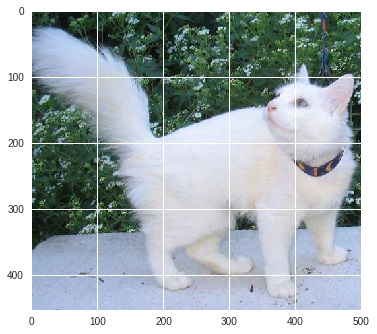

In [33]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [34]:
img.shape

(453, 500, 3)

## Our first model: quick start
We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on resnet models. We'll be studying them in depth later, but for now we'll focus on using them effectively.

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = 'data/dogscats'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

#check if GPU is available
use_gpu = torch.cuda.is_available()

In [37]:
base_model = torchvision.models.resnet34(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26659623.59it/s]


In [0]:
base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)

In [0]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return x
    
    def calculate_loss(self, outputs, targets, **kwargs):
        return F.nll_loss(input=outputs, target=targets)

    def calculate_metrics(self, outputs, targets, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return classification_accuracy

In [0]:
model_conv = MyModel(base_model)

if torch.cuda.is_available():
    model_conv.cuda()

In [0]:
optimizer_conv = optim.Adam(model_conv.base_model.fc.parameters(),weight_decay=1e-4)

In [0]:
train_conv = train.Trainer(model_conv,dataloaders['train'],dataloaders['valid'],optimizer_conv)

  0%|          | 0/360 [00:00<?, ?it/s]

Trying learning rates between 1e-05 and 10 over 100 steps (1 epochs)
Epoch 0/0
----------


  0%|          | 1/360 [00:00<04:45,  1.26it/s]

Iteration No:1 Learn rate 1.00E-05 Batch Loss: 0.7741 Batch Accuracy: 0.4375 


  1%|          | 2/360 [00:01<04:36,  1.29it/s]

Iteration No:2 Learn rate 1.15E-05 Batch Loss: 0.8038 Batch Accuracy: 0.4688 


  1%|          | 3/360 [00:02<04:33,  1.31it/s]

Iteration No:3 Learn rate 1.32E-05 Batch Loss: 0.7803 Batch Accuracy: 0.3906 


  1%|          | 4/360 [00:03<04:29,  1.32it/s]

Iteration No:4 Learn rate 1.51E-05 Batch Loss: 0.7415 Batch Accuracy: 0.5469 


  1%|▏         | 5/360 [00:03<04:27,  1.33it/s]

Iteration No:5 Learn rate 1.74E-05 Batch Loss: 0.7795 Batch Accuracy: 0.3750 


  2%|▏         | 6/360 [00:04<04:26,  1.33it/s]

Iteration No:6 Learn rate 2.00E-05 Batch Loss: 0.7734 Batch Accuracy: 0.4688 


  2%|▏         | 7/360 [00:05<04:24,  1.34it/s]

Iteration No:7 Learn rate 2.29E-05 Batch Loss: 0.8751 Batch Accuracy: 0.3125 


  2%|▏         | 8/360 [00:05<04:23,  1.34it/s]

Iteration No:8 Learn rate 2.63E-05 Batch Loss: 0.7880 Batch Accuracy: 0.3906 


  2%|▎         | 9/360 [00:06<04:22,  1.34it/s]

Iteration No:9 Learn rate 3.02E-05 Batch Loss: 0.8191 Batch Accuracy: 0.3906 


  3%|▎         | 10/360 [00:07<04:22,  1.34it/s]

Iteration No:10 Learn rate 3.47E-05 Batch Loss: 0.7282 Batch Accuracy: 0.5000 


  3%|▎         | 11/360 [00:08<04:20,  1.34it/s]

Iteration No:11 Learn rate 3.98E-05 Batch Loss: 0.7078 Batch Accuracy: 0.5312 


  3%|▎         | 12/360 [00:08<04:19,  1.34it/s]

Iteration No:12 Learn rate 4.57E-05 Batch Loss: 0.7831 Batch Accuracy: 0.4688 


  4%|▎         | 13/360 [00:09<04:18,  1.34it/s]

Iteration No:13 Learn rate 5.25E-05 Batch Loss: 0.7813 Batch Accuracy: 0.4688 


  4%|▍         | 14/360 [00:10<04:17,  1.34it/s]

Iteration No:14 Learn rate 6.03E-05 Batch Loss: 0.7348 Batch Accuracy: 0.5312 


  4%|▍         | 15/360 [00:11<04:16,  1.35it/s]

Iteration No:15 Learn rate 6.92E-05 Batch Loss: 0.7468 Batch Accuracy: 0.5000 


  4%|▍         | 16/360 [00:11<04:16,  1.34it/s]

Iteration No:16 Learn rate 7.94E-05 Batch Loss: 0.7342 Batch Accuracy: 0.5781 


  5%|▍         | 17/360 [00:12<04:14,  1.35it/s]

Iteration No:17 Learn rate 9.12E-05 Batch Loss: 0.7471 Batch Accuracy: 0.4688 


  5%|▌         | 18/360 [00:13<04:14,  1.34it/s]

Iteration No:18 Learn rate 1.05E-04 Batch Loss: 0.7510 Batch Accuracy: 0.4375 


  5%|▌         | 19/360 [00:14<04:14,  1.34it/s]

Iteration No:19 Learn rate 1.20E-04 Batch Loss: 0.7896 Batch Accuracy: 0.4688 


  6%|▌         | 20/360 [00:14<04:12,  1.34it/s]

Iteration No:20 Learn rate 1.38E-04 Batch Loss: 0.7255 Batch Accuracy: 0.5000 


  6%|▌         | 21/360 [00:15<04:12,  1.34it/s]

Iteration No:21 Learn rate 1.58E-04 Batch Loss: 0.7141 Batch Accuracy: 0.5781 


  6%|▌         | 22/360 [00:16<04:11,  1.34it/s]

Iteration No:22 Learn rate 1.82E-04 Batch Loss: 0.7255 Batch Accuracy: 0.5000 


  6%|▋         | 23/360 [00:17<04:10,  1.34it/s]

Iteration No:23 Learn rate 2.09E-04 Batch Loss: 0.7678 Batch Accuracy: 0.4062 


  7%|▋         | 24/360 [00:17<04:10,  1.34it/s]

Iteration No:24 Learn rate 2.40E-04 Batch Loss: 0.7574 Batch Accuracy: 0.5312 


  7%|▋         | 25/360 [00:18<04:09,  1.34it/s]

Iteration No:25 Learn rate 2.75E-04 Batch Loss: 0.6738 Batch Accuracy: 0.5469 


  7%|▋         | 26/360 [00:19<04:08,  1.34it/s]

Iteration No:26 Learn rate 3.16E-04 Batch Loss: 0.7263 Batch Accuracy: 0.4219 


  8%|▊         | 27/360 [00:20<04:07,  1.35it/s]

Iteration No:27 Learn rate 3.63E-04 Batch Loss: 0.6288 Batch Accuracy: 0.6406 


  8%|▊         | 28/360 [00:20<04:06,  1.35it/s]

Iteration No:28 Learn rate 4.17E-04 Batch Loss: 0.6647 Batch Accuracy: 0.6562 


  8%|▊         | 29/360 [00:21<04:06,  1.34it/s]

Iteration No:29 Learn rate 4.79E-04 Batch Loss: 0.6058 Batch Accuracy: 0.6250 


  8%|▊         | 30/360 [00:22<04:05,  1.34it/s]

Iteration No:30 Learn rate 5.50E-04 Batch Loss: 0.5598 Batch Accuracy: 0.7656 


  9%|▊         | 31/360 [00:23<04:04,  1.34it/s]

Iteration No:31 Learn rate 6.31E-04 Batch Loss: 0.6008 Batch Accuracy: 0.7344 


  9%|▉         | 32/360 [00:23<04:03,  1.34it/s]

Iteration No:32 Learn rate 7.24E-04 Batch Loss: 0.5348 Batch Accuracy: 0.8125 


  9%|▉         | 33/360 [00:24<04:02,  1.35it/s]

Iteration No:33 Learn rate 8.32E-04 Batch Loss: 0.5386 Batch Accuracy: 0.7500 


  9%|▉         | 34/360 [00:25<04:02,  1.35it/s]

Iteration No:34 Learn rate 9.55E-04 Batch Loss: 0.5190 Batch Accuracy: 0.7969 


 10%|▉         | 35/360 [00:26<04:01,  1.34it/s]

Iteration No:35 Learn rate 1.10E-03 Batch Loss: 0.4047 Batch Accuracy: 0.8906 


 10%|█         | 36/360 [00:26<04:00,  1.35it/s]

Iteration No:36 Learn rate 1.26E-03 Batch Loss: 0.4729 Batch Accuracy: 0.7969 


 10%|█         | 37/360 [00:27<03:59,  1.35it/s]

Iteration No:37 Learn rate 1.45E-03 Batch Loss: 0.4092 Batch Accuracy: 0.9062 


 11%|█         | 38/360 [00:28<03:59,  1.35it/s]

Iteration No:38 Learn rate 1.66E-03 Batch Loss: 0.3930 Batch Accuracy: 0.8594 


 11%|█         | 39/360 [00:28<03:58,  1.35it/s]

Iteration No:39 Learn rate 1.91E-03 Batch Loss: 0.3087 Batch Accuracy: 0.9375 


 11%|█         | 40/360 [00:29<03:57,  1.35it/s]

Iteration No:40 Learn rate 2.19E-03 Batch Loss: 0.3031 Batch Accuracy: 0.9219 


 11%|█▏        | 41/360 [00:30<03:56,  1.35it/s]

Iteration No:41 Learn rate 2.51E-03 Batch Loss: 0.3031 Batch Accuracy: 0.9062 


 12%|█▏        | 42/360 [00:31<03:56,  1.35it/s]

Iteration No:42 Learn rate 2.88E-03 Batch Loss: 0.3590 Batch Accuracy: 0.7969 


 12%|█▏        | 43/360 [00:31<03:55,  1.35it/s]

Iteration No:43 Learn rate 3.31E-03 Batch Loss: 0.2234 Batch Accuracy: 0.9531 


 12%|█▏        | 44/360 [00:32<03:54,  1.35it/s]

Iteration No:44 Learn rate 3.80E-03 Batch Loss: 0.2462 Batch Accuracy: 0.9219 


 12%|█▎        | 45/360 [00:33<03:53,  1.35it/s]

Iteration No:45 Learn rate 4.37E-03 Batch Loss: 0.2226 Batch Accuracy: 0.9219 


 13%|█▎        | 46/360 [00:34<03:52,  1.35it/s]

Iteration No:46 Learn rate 5.01E-03 Batch Loss: 0.1889 Batch Accuracy: 0.9375 


 13%|█▎        | 47/360 [00:34<03:52,  1.35it/s]

Iteration No:47 Learn rate 5.75E-03 Batch Loss: 0.1460 Batch Accuracy: 0.9531 


 13%|█▎        | 48/360 [00:35<03:51,  1.35it/s]

Iteration No:48 Learn rate 6.61E-03 Batch Loss: 0.1282 Batch Accuracy: 0.9844 


 14%|█▎        | 49/360 [00:36<03:51,  1.35it/s]

Iteration No:49 Learn rate 7.59E-03 Batch Loss: 0.1479 Batch Accuracy: 0.9375 


 14%|█▍        | 50/360 [00:37<03:50,  1.35it/s]

Iteration No:50 Learn rate 8.71E-03 Batch Loss: 0.1020 Batch Accuracy: 0.9531 


 14%|█▍        | 51/360 [00:37<03:49,  1.35it/s]

Iteration No:51 Learn rate 1.00E-02 Batch Loss: 0.1983 Batch Accuracy: 0.8750 


 14%|█▍        | 52/360 [00:38<03:48,  1.35it/s]

Iteration No:52 Learn rate 1.15E-02 Batch Loss: 0.1617 Batch Accuracy: 0.9375 


 15%|█▍        | 53/360 [00:39<03:48,  1.34it/s]

Iteration No:53 Learn rate 1.32E-02 Batch Loss: 0.1737 Batch Accuracy: 0.9375 


 15%|█▌        | 54/360 [00:40<03:47,  1.35it/s]

Iteration No:54 Learn rate 1.51E-02 Batch Loss: 0.0922 Batch Accuracy: 0.9844 


 15%|█▌        | 55/360 [00:40<03:46,  1.35it/s]

Iteration No:55 Learn rate 1.74E-02 Batch Loss: 0.1558 Batch Accuracy: 0.8906 


 16%|█▌        | 56/360 [00:41<03:46,  1.35it/s]

Iteration No:56 Learn rate 2.00E-02 Batch Loss: 0.1980 Batch Accuracy: 0.8750 


 16%|█▌        | 57/360 [00:42<03:45,  1.35it/s]

Iteration No:57 Learn rate 2.29E-02 Batch Loss: 0.2139 Batch Accuracy: 0.9219 


 16%|█▌        | 58/360 [00:43<03:44,  1.35it/s]

Iteration No:58 Learn rate 2.63E-02 Batch Loss: 0.1747 Batch Accuracy: 0.9375 


 16%|█▋        | 59/360 [00:43<03:43,  1.35it/s]

Iteration No:59 Learn rate 3.02E-02 Batch Loss: 0.1388 Batch Accuracy: 0.9375 


 17%|█▋        | 60/360 [00:44<03:42,  1.35it/s]

Iteration No:60 Learn rate 3.47E-02 Batch Loss: 0.1564 Batch Accuracy: 0.9219 


 17%|█▋        | 61/360 [00:45<03:41,  1.35it/s]

Iteration No:61 Learn rate 3.98E-02 Batch Loss: 0.7399 Batch Accuracy: 0.7656 


 17%|█▋        | 62/360 [00:45<03:40,  1.35it/s]

Iteration No:62 Learn rate 4.57E-02 Batch Loss: 0.0824 Batch Accuracy: 0.9688 


 18%|█▊        | 63/360 [00:46<03:40,  1.35it/s]

Iteration No:63 Learn rate 5.25E-02 Batch Loss: 0.2005 Batch Accuracy: 0.9062 


 18%|█▊        | 64/360 [00:47<03:39,  1.35it/s]

Iteration No:64 Learn rate 6.03E-02 Batch Loss: 0.9065 Batch Accuracy: 0.7812 


 18%|█▊        | 65/360 [00:48<03:38,  1.35it/s]

Iteration No:65 Learn rate 6.92E-02 Batch Loss: 0.6477 Batch Accuracy: 0.8281 


 18%|█▊        | 66/360 [00:48<03:37,  1.35it/s]

Iteration No:66 Learn rate 7.94E-02 Batch Loss: 0.3305 Batch Accuracy: 0.9219 


 19%|█▊        | 67/360 [00:49<03:36,  1.35it/s]

Iteration No:67 Learn rate 9.12E-02 Batch Loss: 0.2494 Batch Accuracy: 0.9219 


 19%|█▉        | 68/360 [00:50<03:36,  1.35it/s]

Iteration No:68 Learn rate 1.05E-01 Batch Loss: 0.3476 Batch Accuracy: 0.9219 


 19%|█▉        | 69/360 [00:51<03:35,  1.35it/s]

Iteration No:69 Learn rate 1.20E-01 Batch Loss: 1.4808 Batch Accuracy: 0.8281 


 19%|█▉        | 70/360 [00:51<03:34,  1.35it/s]

Iteration No:70 Learn rate 1.38E-01 Batch Loss: 0.2033 Batch Accuracy: 0.9531 


 20%|█▉        | 71/360 [00:52<03:34,  1.35it/s]

Iteration No:71 Learn rate 1.58E-01 Batch Loss: 2.2773 Batch Accuracy: 0.7031 


 20%|██        | 72/360 [00:53<03:33,  1.35it/s]

Iteration No:72 Learn rate 1.82E-01 Batch Loss: 0.7142 Batch Accuracy: 0.8750 


 20%|██        | 73/360 [00:54<03:32,  1.35it/s]

Iteration No:73 Learn rate 2.09E-01 Batch Loss: 2.1397 Batch Accuracy: 0.7656 


 21%|██        | 74/360 [00:54<03:31,  1.35it/s]

Iteration No:74 Learn rate 2.40E-01 Batch Loss: 0.3155 Batch Accuracy: 0.9375 


 21%|██        | 75/360 [00:55<03:31,  1.35it/s]

Iteration No:75 Learn rate 2.75E-01 Batch Loss: 5.1826 Batch Accuracy: 0.7031 


 21%|██        | 76/360 [00:56<03:30,  1.35it/s]

Iteration No:76 Learn rate 3.16E-01 Batch Loss: 0.7601 Batch Accuracy: 0.9375 


 21%|██▏       | 77/360 [00:57<03:29,  1.35it/s]

Iteration No:77 Learn rate 3.63E-01 Batch Loss: 5.9837 Batch Accuracy: 0.6406 


 22%|██▏       | 78/360 [00:57<03:28,  1.35it/s]

Iteration No:78 Learn rate 4.17E-01 Batch Loss: 2.3636 Batch Accuracy: 0.8438 


 22%|██▏       | 79/360 [00:58<03:28,  1.35it/s]

Iteration No:79 Learn rate 4.79E-01 Batch Loss: 7.8196 Batch Accuracy: 0.7188 


 22%|██▏       | 80/360 [00:59<03:27,  1.35it/s]

Iteration No:80 Learn rate 5.50E-01 Batch Loss: 2.0778 Batch Accuracy: 0.9219 


 22%|██▎       | 81/360 [01:00<03:26,  1.35it/s]

Iteration No:81 Learn rate 6.31E-01 Batch Loss: 8.7814 Batch Accuracy: 0.7188 


 23%|██▎       | 82/360 [01:00<03:25,  1.35it/s]

Iteration No:82 Learn rate 7.24E-01 Batch Loss: 1.2181 Batch Accuracy: 0.9531 


 23%|██▎       | 83/360 [01:01<03:25,  1.35it/s]

Iteration No:83 Learn rate 8.32E-01 Batch Loss: 5.4501 Batch Accuracy: 0.8906 


 23%|██▎       | 84/360 [01:02<03:24,  1.35it/s]

Iteration No:84 Learn rate 9.55E-01 Batch Loss: 11.7392 Batch Accuracy: 0.7344 


 24%|██▎       | 85/360 [01:02<03:23,  1.35it/s]

Iteration No:85 Learn rate 1.10E+00 Batch Loss: 5.4198 Batch Accuracy: 0.8906 


 24%|██▍       | 86/360 [01:03<03:23,  1.35it/s]

Iteration No:86 Learn rate 1.26E+00 Batch Loss: 60.7932 Batch Accuracy: 0.4531 


 24%|██▍       | 87/360 [01:04<03:22,  1.35it/s]

Iteration No:87 Learn rate 1.45E+00 Batch Loss: 7.8361 Batch Accuracy: 0.7969 


 24%|██▍       | 88/360 [01:05<03:21,  1.35it/s]

Iteration No:88 Learn rate 1.66E+00 Batch Loss: 47.2263 Batch Accuracy: 0.5625 


 25%|██▍       | 89/360 [01:05<03:20,  1.35it/s]

Iteration No:89 Learn rate 1.91E+00 Batch Loss: 5.8181 Batch Accuracy: 0.9375 


 25%|██▌       | 90/360 [01:06<03:19,  1.35it/s]

Iteration No:90 Learn rate 2.19E+00 Batch Loss: 36.6782 Batch Accuracy: 0.7344 


 25%|██▌       | 91/360 [01:07<03:19,  1.35it/s]

Iteration No:91 Learn rate 2.51E+00 Batch Loss: 52.7272 Batch Accuracy: 0.7656 


 26%|██▌       | 92/360 [01:08<03:18,  1.35it/s]

Iteration No:92 Learn rate 2.88E+00 Batch Loss: 3.5545 Batch Accuracy: 0.9531 


 26%|██▌       | 93/360 [01:08<03:17,  1.35it/s]

Iteration No:93 Learn rate 3.31E+00 Batch Loss: 36.8362 Batch Accuracy: 0.7969 


 26%|██▌       | 94/360 [01:09<03:16,  1.35it/s]

Iteration No:94 Learn rate 3.80E+00 Batch Loss: 65.4086 Batch Accuracy: 0.7188 


 26%|██▋       | 95/360 [01:10<03:15,  1.35it/s]

Iteration No:95 Learn rate 4.37E+00 Batch Loss: 14.5307 Batch Accuracy: 0.8906 


 27%|██▋       | 96/360 [01:11<03:15,  1.35it/s]

Iteration No:96 Learn rate 5.01E+00 Batch Loss: 42.0366 Batch Accuracy: 0.8594 


 27%|██▋       | 97/360 [01:11<03:14,  1.35it/s]

Iteration No:97 Learn rate 5.75E+00 Batch Loss: 47.1107 Batch Accuracy: 0.8438 


 27%|██▋       | 98/360 [01:12<03:13,  1.35it/s]

Iteration No:98 Learn rate 6.61E+00 Batch Loss: 4.4586 Batch Accuracy: 0.9688 
Iteration No:99 Learn rate 7.59E+00 Batch Loss: 1.3660 Batch Accuracy: 0.9531 


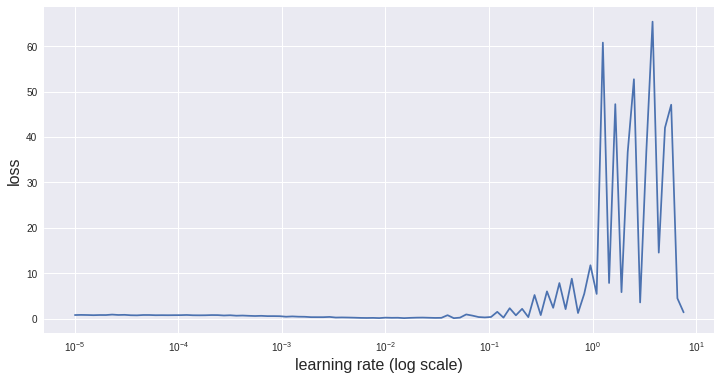

In [43]:
train_conv.lr_find(steps=100)

  0%|          | 0/360 [00:00<?, ?it/s]

Epoch 0/1
----------


  0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1782 Acc: 0.9260


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


val Loss: 0.0450 Acc: 0.9850


  0%|          | 0/360 [00:00<?, ?it/s]


Epoch 1/1
----------


  0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 0.1312 Acc: 0.9431


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


val Loss: 0.0359 Acc: 0.9895

Training complete in 9m 27s
Best val Acc: 0.989500


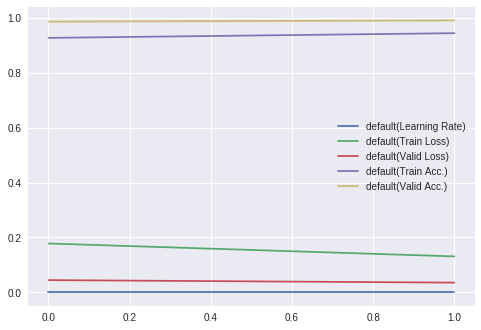

In [148]:
model_conv = train_conv.train_model(optimizer=optimizer_conv, num_epochs=2)

100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


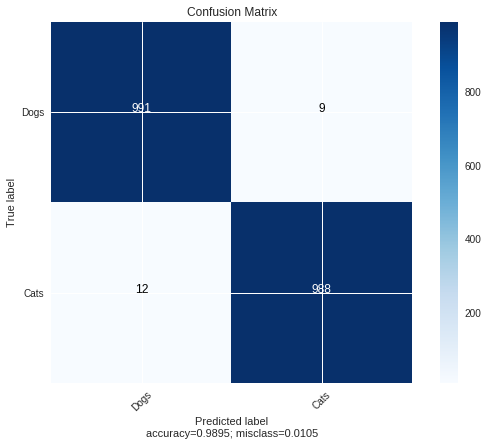

In [149]:
probs,target = train_conv.predict_with_targs()
preds = np.argmax(probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, preds)
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Dogs', 'Cats'],
                      title        = "Confusion Matrix")

0it [00:00, ?it/s]

Trying learning rates between 1e-05 and 10 over 100 steps (1 epochs)
Epoch 0/0
----------


1it [00:00,  1.26it/s]

Batch No:0 Learn rate 1.00E-05 Batch Loss: 0.7720 


2it [00:01,  1.27it/s]

Batch No:1 Learn rate 1.15E-05 Batch Loss: 0.7064 


3it [00:02,  1.29it/s]

Batch No:2 Learn rate 1.32E-05 Batch Loss: 0.6915 


4it [00:03,  1.31it/s]

Batch No:3 Learn rate 1.51E-05 Batch Loss: 0.7612 


5it [00:03,  1.32it/s]

Batch No:4 Learn rate 1.74E-05 Batch Loss: 0.7099 


6it [00:04,  1.33it/s]

Batch No:5 Learn rate 2.00E-05 Batch Loss: 0.6358 


7it [00:05,  1.33it/s]

Batch No:6 Learn rate 2.29E-05 Batch Loss: 0.5619 


8it [00:06,  1.33it/s]

Batch No:7 Learn rate 2.63E-05 Batch Loss: 0.4964 


9it [00:06,  1.33it/s]

Batch No:8 Learn rate 3.02E-05 Batch Loss: 0.4921 


10it [00:07,  1.33it/s]

Batch No:9 Learn rate 3.47E-05 Batch Loss: 0.4081 


11it [00:08,  1.33it/s]

Batch No:10 Learn rate 3.98E-05 Batch Loss: 0.3226 


12it [00:09,  1.33it/s]

Batch No:11 Learn rate 4.57E-05 Batch Loss: 0.2614 


13it [00:09,  1.33it/s]

Batch No:12 Learn rate 5.25E-05 Batch Loss: 0.2268 


14it [00:10,  1.33it/s]

Batch No:13 Learn rate 6.03E-05 Batch Loss: 0.2027 


15it [00:11,  1.33it/s]

Batch No:14 Learn rate 6.92E-05 Batch Loss: 0.2348 


16it [00:11,  1.34it/s]

Batch No:15 Learn rate 7.94E-05 Batch Loss: 0.1756 


17it [00:12,  1.34it/s]

Batch No:16 Learn rate 9.12E-05 Batch Loss: 0.1690 


18it [00:13,  1.34it/s]

Batch No:17 Learn rate 1.05E-04 Batch Loss: 0.0983 


19it [00:14,  1.34it/s]

Batch No:18 Learn rate 1.20E-04 Batch Loss: 0.1810 


20it [00:14,  1.34it/s]

Batch No:19 Learn rate 1.38E-04 Batch Loss: 0.2665 


21it [00:15,  1.34it/s]

Batch No:20 Learn rate 1.58E-04 Batch Loss: 0.1212 


22it [00:16,  1.34it/s]

Batch No:21 Learn rate 1.82E-04 Batch Loss: 0.1645 


23it [00:17,  1.34it/s]

Batch No:22 Learn rate 2.09E-04 Batch Loss: 0.2155 


24it [00:17,  1.34it/s]

Batch No:23 Learn rate 2.40E-04 Batch Loss: 0.1858 


25it [00:18,  1.34it/s]

Batch No:24 Learn rate 2.75E-04 Batch Loss: 0.3402 


26it [00:19,  1.34it/s]

Batch No:25 Learn rate 3.16E-04 Batch Loss: 0.0625 


27it [00:20,  1.34it/s]

Batch No:26 Learn rate 3.63E-04 Batch Loss: 0.1287 


28it [00:20,  1.34it/s]

Batch No:27 Learn rate 4.17E-04 Batch Loss: 0.1105 


29it [00:21,  1.34it/s]

Batch No:28 Learn rate 4.79E-04 Batch Loss: 0.0619 


30it [00:22,  1.34it/s]

Batch No:29 Learn rate 5.50E-04 Batch Loss: 0.0981 


31it [00:23,  1.34it/s]

Batch No:30 Learn rate 6.31E-04 Batch Loss: 0.1165 


32it [00:23,  1.34it/s]

Batch No:31 Learn rate 7.24E-04 Batch Loss: 0.3799 


33it [00:24,  1.34it/s]

Batch No:32 Learn rate 8.32E-04 Batch Loss: 0.6266 


34it [00:25,  1.34it/s]

Batch No:33 Learn rate 9.55E-04 Batch Loss: 0.0966 


35it [00:26,  1.34it/s]

Batch No:34 Learn rate 1.10E-03 Batch Loss: 0.5807 


36it [00:26,  1.34it/s]

Batch No:35 Learn rate 1.26E-03 Batch Loss: 0.7085 


37it [00:27,  1.34it/s]

Batch No:36 Learn rate 1.45E-03 Batch Loss: 0.9487 


38it [00:28,  1.34it/s]

Batch No:37 Learn rate 1.66E-03 Batch Loss: 0.9425 


39it [00:29,  1.34it/s]

Batch No:38 Learn rate 1.91E-03 Batch Loss: 0.2081 
Batch No:39 Learn rate 2.19E-03 Batch Loss: 1.8388 


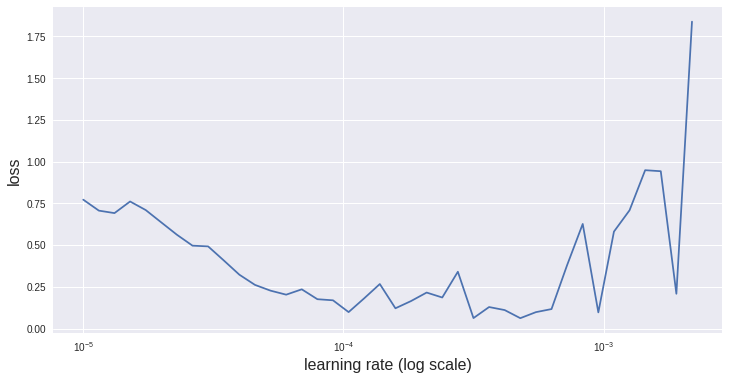

In [59]:
train_conv.lr_find(steps=100)

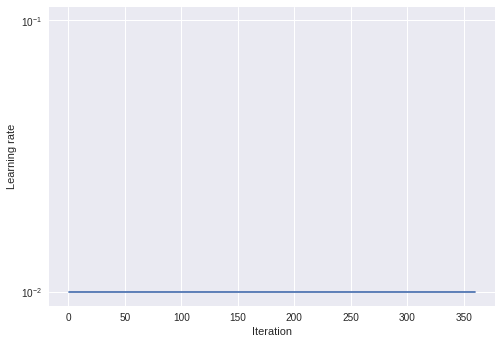

In [68]:
train_conv.plot_lr()

##Choosing a learning rate
The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.